# **1. Environment Setup & Path Verification**

This step prepares the FD002 workspace by:

- Initializing logging and establishing reproducibility with a fixed random seed  
- Mounting Google Drive when running inside Google Colab  
- Defining all required FD002 dataset paths (train, test, RUL files)  
- Verifying file availability to prevent downstream pipeline failures  

Completing this ensures FD002 data is correctly located and ready for processing.

In [1]:
# 1. Environment Setup & Path Verification (FD002)


import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# 1. Logging helper

def log(msg):
    print(f"[INFO] {msg}")


# 2. Reproducibility

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

log(f"Seed fixed at {SEED} for reproducibility.")


# 3. Mount Google Drive (Colab)

try:
    from google.colab import drive
    log("Mounting Google Drive...")
    drive.mount('/content/drive')
    log("Google Drive mounted successfully.")
except ImportError:
    log("Not running in Colab — skipping drive.mount().")


# 4. FD002 Data Directory

BASE_PATH_FD002 = "/content/drive/MyDrive/OIL PREDICTIVE MAINTAINANCE/CMaps"

train_path_fd002 = os.path.join(BASE_PATH_FD002, "train_FD002.txt")
test_path_fd002  = os.path.join(BASE_PATH_FD002, "test_FD002.txt")
rul_path_fd002   = os.path.join(BASE_PATH_FD002, "RUL_FD002.txt")

log("FD002 expected file paths:")
print("   Train:", train_path_fd002)
print("   Test :", test_path_fd002)
print("   RUL  :", rul_path_fd002)


# 5. Verify file existence

missing = []
for p in [train_path_fd002, test_path_fd002, rul_path_fd002]:
    if os.path.exists(p):
        print(f" Found: {p}")
    else:
        print(f" Missing: {p}")
        missing.append(p)

if missing:
    raise FileNotFoundError(
        " ERROR: Required FD002 files are missing:\n" +
        "\n".join(missing)
    )

log("FD002 environment ready.")


[INFO] Seed fixed at 42 for reproducibility.
[INFO] Mounting Google Drive...
Mounted at /content/drive
[INFO] Google Drive mounted successfully.
[INFO] FD002 expected file paths:
   Train: /content/drive/MyDrive/OIL PREDICTIVE MAINTAINANCE/CMaps/train_FD002.txt
   Test : /content/drive/MyDrive/OIL PREDICTIVE MAINTAINANCE/CMaps/test_FD002.txt
   RUL  : /content/drive/MyDrive/OIL PREDICTIVE MAINTAINANCE/CMaps/RUL_FD002.txt
 Found: /content/drive/MyDrive/OIL PREDICTIVE MAINTAINANCE/CMaps/train_FD002.txt
 Found: /content/drive/MyDrive/OIL PREDICTIVE MAINTAINANCE/CMaps/test_FD002.txt
 Found: /content/drive/MyDrive/OIL PREDICTIVE MAINTAINANCE/CMaps/RUL_FD002.txt
[INFO] FD002 environment ready.


# **2. Load FD002 Dataset**

This step loads all three FD002 files and assigns the correct NASA CMAPSS schema:

- **train_FD002.txt** → full engine run-to-failure sequences  
- **test_FD002.txt** → truncated sequences (final windows used for prediction)  
- **RUL_FD002.txt** → true remaining life for each test engine  

We define the expected 26-column structure (unit ID, cycle, 3 settings, 21 sensors) and validate that the loaded files match this schema.  
A preview of all datasets is shown for sanity checking before preprocessing.

In [2]:
# 2. Load FD002 Dataset


print(" LOADING FD002 DATASET ")

# Expected schema (5 settings + 21 sensors = 26 columns)
fd002_cols = (
    ["unit", "cycle", "setting1", "setting2", "setting3"] +
    [f"sensor{i}" for i in range(1, 22)]
)

# Load raw files
train_fd002 = pd.read_csv(train_path_fd002, sep=r"\s+", header=None, names=fd002_cols)
test_fd002  = pd.read_csv(test_path_fd002,  sep=r"\s+", header=None, names=fd002_cols)
rul_fd002   = pd.read_csv(rul_path_fd002,   sep=r"\s+", header=None, names=["RUL"])

# Basic shape verification
print(f"TRAIN SHAPE: {train_fd002.shape}")
print(f"TEST SHAPE : {test_fd002.shape}")
print(f"RUL SHAPE  : {rul_fd002.shape}")

# Schema check
if train_fd002.shape[1] != len(fd002_cols):
    raise ValueError(f" TRAIN schema mismatch. Expected {len(fd002_cols)} columns, found {train_fd002.shape[1]}.")

if test_fd002.shape[1] != len(fd002_cols):
    raise ValueError(f" TEST schema mismatch. Expected {len(fd002_cols)} columns, found {test_fd002.shape[1]}.")

print("Schema check passed. Columns correctly assigned.")

# Display preview
print("\n TRAIN SAMPLE ")
display(train_fd002.head())

print("\n TEST SAMPLE ")
display(test_fd002.head())

print("\n RUL SAMPLE ")
display(rul_fd002.head())

print("\n Dataset loaded successfully.")


 LOADING FD002 DATASET 
TRAIN SHAPE: (53759, 26)
TEST SHAPE : (33991, 26)
RUL SHAPE  : (259, 1)
Schema check passed. Columns correctly assigned.

 TRAIN SAMPLE 


,unit,cycle,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,183.06,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,130.42,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,164.22,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,130.72,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,164.31,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286



 TEST SAMPLE 


,unit,cycle,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,9.9987,0.2502,100.0,489.05,605.03,1497.17,1304.99,10.52,...,371.69,2388.18,8114.10,8.6476,0.03,369,2319,100.00,28.42,17.1551
1,1,2,20.0026,0.7000,100.0,491.19,607.82,1481.20,1246.11,9.35,...,315.32,2388.12,8053.06,9.2405,0.02,364,2324,100.00,24.29,14.8039
2,1,3,35.0045,0.8400,100.0,449.44,556.00,1359.08,1128.36,5.48,...,183.04,2387.75,8053.04,9.3472,0.02,333,2223,100.00,14.98,8.9125
3,1,4,42.0066,0.8410,100.0,445.00,550.17,1349.69,1127.89,3.91,...,130.40,2387.72,8066.90,9.3961,0.02,332,2212,100.00,10.35,6.4181
4,1,5,24.9985,0.6213,60.0,462.54,536.72,1253.18,1050.69,7.05,...,164.56,2028.05,7865.66,10.8682,0.02,305,1915,84.93,14.31,8.5740



 RUL SAMPLE 


,RUL
0,18
1,79
2,106
3,110
4,15



 Dataset loaded successfully.


# **3. DEEP DATA INTEGRITY CHECK**

This step performs a strict structural and statistical validation of the FD002 dataset before any preprocessing.  
NASA CMAPSS data is usually clean, but integrity failures (NaNs, duplicated rows, broken cycle sequences) can silently break RUL modeling pipelines.

**Checks performed:**

1. **Null / NaN validation** — ensures there are no missing values in train or test.  
2. **Duplicate detection** — duplicate rows can distort temporal modeling.  
3. **Data type summary** — confirms numeric consistency across features.  
4. **Sensor range inspection** — validates typical CMAPSS sensor distributions.  
5. **Cycle continuity check** — each engine must progress cycle-by-cycle without gaps.  
6. **Negative sensor value check** — unusual negative values may indicate corrupted rows.

If all checks pass, FD002 is confirmed safe for downstream feature engineering and modeling.

In [3]:
# 3. Deep Data Integrity Check (FD002)

print(" FD002 DATA INTEGRITY CHECK ")


# 1. NULL / NaN CHECK

print("\n[CHECK] Null / NaN values in TRAIN:")
null_train = train_fd002.isna().sum().sum()
print("Total NaNs:", null_train)

print("\n[CHECK] Null / NaN values in TEST:")
null_test = test_fd002.isna().sum().sum()
print("Total NaNs:", null_test)

if null_train > 0 or null_test > 0:
    raise ValueError(" DATA ISSUE: NaN values detected.")

print(" No NaN values detected.")

# 2. DUPLICATES CHECK

dup_train = train_fd002.duplicated().sum()
dup_test  = test_fd002.duplicated().sum()

print(f"\n[CHECK] Duplicate rows in TRAIN: {dup_train}")
print(f"[CHECK] Duplicate rows in TEST : {dup_test}")

if dup_train > 0:
    print(" WARNING: TRAIN contains duplicate rows.")

# 3. DTYPE CHECK

print("\n[CHECK] Data Types Summary:")
print(train_fd002.dtypes.value_counts())

# 4. SENSOR RANGE CHECK

sensor_cols = [c for c in train_fd002.columns if c.startswith("sensor")]

print("\n[CHECK] Sensor Value Ranges (TRAIN) — first 10 sensors:")
display(train_fd002[sensor_cols].describe().T.head(10))


# 5. CYCLE CONSISTENCY CHECK

print("\n[CHECK] Cycle sequence consistency...")

# Each unit must start from cycle=1 and increase by steps of 1
broken_units = []

for u, df_u in train_fd002.groupby("unit"):
    cycles = df_u["cycle"].values
    if not np.all(np.diff(cycles) == 1):
        broken_units.append(u)

if broken_units:
    print(" WARNING: Some units have broken cycle sequence:", broken_units[:10])
else:
    print(" All units have consistent cycle progression.")

# 6. BASIC SANITY CHECKS — NEGATIVE VALUES?

neg_vals = (train_fd002[sensor_cols] < 0).sum().sum()
print(f"\n[CHECK] Negative sensor values count: {neg_vals}")

if neg_vals > 0:
    print(" WARNING: Negative sensor readings found. Investigate specific sensors.")
else:
    print(" No negative sensor values.")

print("\nIntegrity Check complete. Data looks structurally sound.")


 FD002 DATA INTEGRITY CHECK 

[CHECK] Null / NaN values in TRAIN:
Total NaNs: 0

[CHECK] Null / NaN values in TEST:
Total NaNs: 0
 No NaN values detected.

[CHECK] Duplicate rows in TRAIN: 0
[CHECK] Duplicate rows in TEST : 0

[CHECK] Data Types Summary:
float64    22
int64       4
Name: count, dtype: int64

[CHECK] Sensor Value Ranges (TRAIN) — first 10 sensors:


,count,mean,std,min,25%,50%,75%,max
sensor1,53759.0,472.910207,26.389707,445.00,445.000,462.54,491.19,518.67
sensor2,53759.0,579.672399,37.289399,535.53,549.570,555.98,607.34,644.52
sensor3,53759.0,1419.971013,105.946341,1243.73,1352.760,1369.18,1499.37,1612.88
sensor4,53759.0,1205.442024,119.123428,1023.77,1123.655,1138.89,1306.85,1439.23
sensor5,53759.0,8.031986,3.613839,3.91,3.910,7.05,10.52,14.62
sensor6,53759.0,11.600746,5.431802,5.71,5.720,9.03,15.49,21.61
sensor7,53759.0,282.606787,146.005306,136.80,139.935,194.66,394.08,555.82
sensor8,53759.0,2228.879188,145.209816,1914.77,2211.880,2223.07,2323.96,2388.39
sensor9,53759.0,8525.200837,335.812013,7985.56,8321.660,8361.20,8778.03,9215.66
sensor10,53759.0,1.094962,0.127469,0.93,1.020,1.02,1.26,1.30



[CHECK] Cycle sequence consistency...
 All units have consistent cycle progression.

[CHECK] Negative sensor values count: 0
 No negative sensor values.

Integrity Check complete. Data looks structurally sound.


# **4. RUL Labeling for FD002 TRAIN**

This step computes Remaining Useful Life (RUL) for every cycle of each engine in the FD002 training set.  
NASA CMAPSS requires RUL to decrease monotonically until the final cycle (RUL = 0).

**Procedure:**

1. **Identify failure point**  
   For each engine, find its maximum cycle (its failure point).

2. **Assign RUL**  
   RUL = max_cycle − current_cycle.

3. **Cap extreme values**  
   To prevent unstable training, RUL is clipped using a fixed NASA convention:  
   **RUL_CAP = 125**.

4. **Integrity checks**  
   - No negative RUL values  
   - RUL strictly decreases for each engine  
   - Last cycle of every engine must have RUL = 0  

If all checks pass, the RUL labels are valid and ready for feature engineering.

In [4]:
# 4. RUL Labeling for FD002 TRAIN


print(" GENERATING RUL LABELS FOR FD002 TRAIN DATA ")

# 1. Compute max cycle per engine
max_cycle_per_unit = train_fd002.groupby("unit")["cycle"].max()

# 2. Map max cycle back to train rows
train_fd002["max_cycle"] = train_fd002["unit"].map(max_cycle_per_unit)

# 3. Compute RUL
train_fd002["RUL"] = train_fd002["max_cycle"] - train_fd002["cycle"]

RUL_CAP = 125
train_fd002["RUL"] = np.minimum(train_fd002["RUL"], RUL_CAP)


# SANITY CHECKS


# (A) RUL must be >= 0
if (train_fd002["RUL"] < 0).any():
    raise ValueError(" ERROR: Negative RUL values detected.")

# (B) RUL must decrease monotonically per engine
broken_units = []
for u, df_u in train_fd002.groupby("unit"):
    rul_values = df_u["RUL"].values
    if not np.all(np.diff(rul_values) <= 0):
        broken_units.append(u)

if broken_units:
    print(" WARNING: Some units have non-monotonic RUL:", broken_units[:10])
else:
    print(" RUL decreases correctly for every engine.")

# (C) Final cycle should have RUL = 0
end_rul_values = train_fd002.groupby("unit")["RUL"].last()
if not np.all(end_rul_values == 0):
    print(" WARNING: Some engines do not end at RUL=0. Inspect dataset.")
else:
    print(" All engines correctly end at RUL = 0.")

# Display samples

print("\n TRAIN SAMPLE WITH RUL ")
display(train_fd002.head())

print("\n LAST ROW OF ENGINE 1 (Should show RUL = 0) ")
display(train_fd002[train_fd002["unit"] == 1].tail())

print("\nFD002 TRAIN RUL labeling complete.")


 GENERATING RUL LABELS FOR FD002 TRAIN DATA 
 RUL decreases correctly for every engine.
 All engines correctly end at RUL = 0.

 TRAIN SAMPLE WITH RUL 


,unit,cycle,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,max_cycle,RUL
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071,149,125
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665,149,125
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723,149,125
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701,149,125
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286,149,125



 LAST ROW OF ENGINE 1 (Should show RUL = 0) 


,unit,cycle,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,max_cycle,RUL
144,1,145,35.0007,0.8402,100.0,449.44,556.59,1376.19,1152.04,5.48,...,8050.29,9.4189,0.02,338,2223,100.00,14.72,8.8240,149,4
145,1,146,10.0006,0.2516,100.0,489.05,605.94,1511.92,1326.50,10.52,...,8113.02,8.7345,0.03,372,2319,100.00,28.16,16.9984,149,3
146,1,147,25.0005,0.6200,60.0,462.54,537.50,1268.62,1057.88,7.05,...,7866.66,10.9764,0.02,310,1915,84.93,14.34,8.4476,149,2
147,1,148,0.0024,0.0013,100.0,518.67,643.73,1605.33,1425.76,14.62,...,8115.88,8.5240,0.03,397,2388,100.00,38.55,23.0079,149,1
148,1,149,42.0017,0.8414,100.0,445.00,550.49,1366.01,1149.81,3.91,...,8066.19,9.4765,0.02,332,2212,100.00,10.45,6.2285,149,0



FD002 TRAIN RUL labeling complete.


# **5. RUL vs Cycle Visualization**

This diagnostic plot helps verify whether sensor trends align with the expected RUL degradation pattern for selected engines.

**Why this step is important:**

- Confirms that **sensor behavior changes** as engines approach failure.  
- Ensures RUL labels reflect meaningful degradation patterns.  
- Helps detect abnormal sensors or noise before sequence modeling.

**What the plots show:**

- **Primary Y-axis (red):** RUL steadily decreasing to 0.  
- **Secondary Y-axis:** Trends of selected sensors (`sensor2`, `sensor3`, `sensor4`, `sensor7`, `sensor8`, `sensor9`).  
- Each engine is visualized separately to observe different failure modes unique to FD002.

This step ensures the dataset behaves realistically before applying rolling/delta feature engineering and sequence creation.

 RUL DEGRADATION ANALYSIS FOR SAMPLE ENGINES 
Engines selected: [1, 10, 50]
Sensors selected: ['sensor2', 'sensor3', 'sensor4', 'sensor7', 'sensor8', 'sensor9']


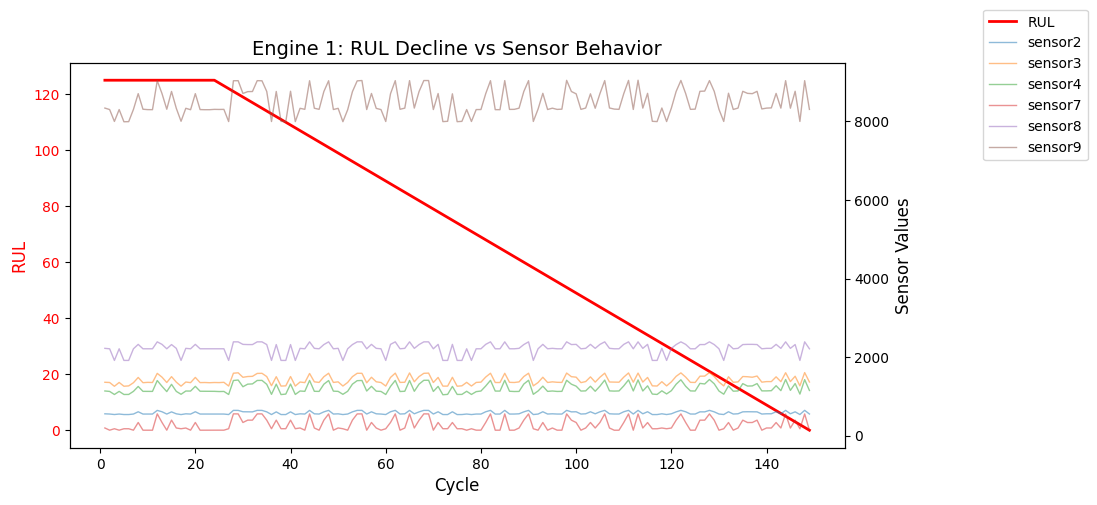

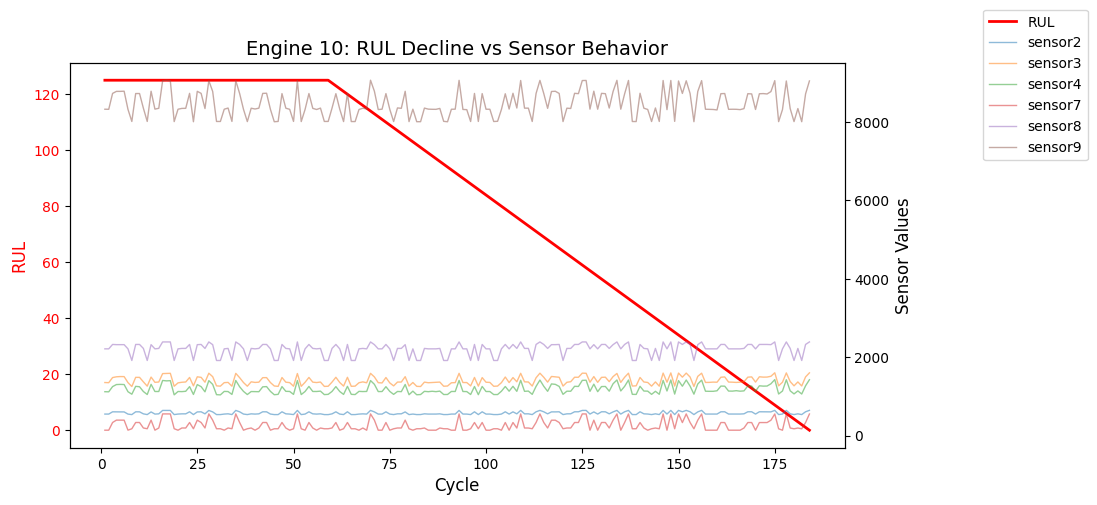

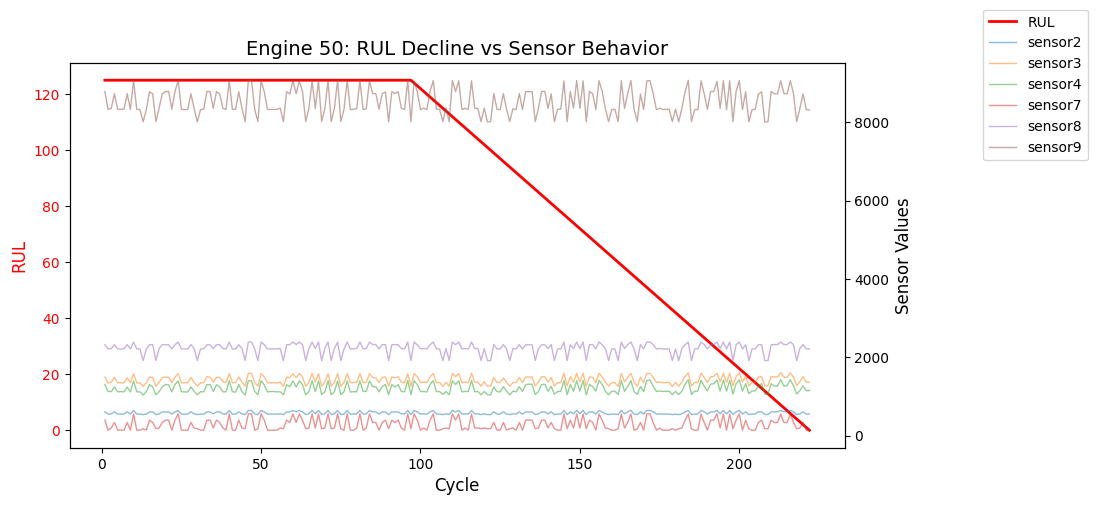


RUL visualization complete.


In [5]:
# 5. Visualize RUL Degradation for Sample Engines

print(" RUL DEGRADATION ANALYSIS FOR SAMPLE ENGINES ")

# Pick engines from TRAIN
sample_units = [1, 10, 50]   # picks stable, different behaviors
sample_units = [u for u in sample_units if u in train_fd002["unit"].unique()]

sensor_plot = ["sensor2", "sensor3", "sensor4", "sensor7", "sensor8", "sensor9"]

print(f"Engines selected: {sample_units}")
print(f"Sensors selected: {sensor_plot}")

for unit in sample_units:
    df_u = train_fd002[train_fd002["unit"] == unit].copy()

    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Plot RUL
    ax1.plot(df_u["cycle"], df_u["RUL"], color="red", label="RUL", linewidth=2)
    ax1.set_xlabel("Cycle", fontsize=12)
    ax1.set_ylabel("RUL", color="red", fontsize=12)
    ax1.tick_params(axis='y', labelcolor="red")

    # Secondary axis for sensors
    ax2 = ax1.twinx()

    for s in sensor_plot:
        ax2.plot(df_u["cycle"], df_u[s], alpha=0.5, linewidth=1, label=s)

    ax2.set_ylabel("Sensor Values", fontsize=12)
    ax2.tick_params(axis='y')

    plt.title(f"Engine {unit}: RUL Decline vs Sensor Behavior", fontsize=14)
    fig.legend(loc="upper right", bbox_to_anchor=(1.15, 1))
    plt.show()

print("\nRUL visualization complete.")


# **6. IDENTIFY USELESS / CONSTANT / NON-INFORMATIVE COLUMNS**

This step ensures the model only learns from meaningful signals.

#### Why this step matters
FD002 contains multiple operating conditions, and some sensors/settings may remain constant across all cycles.  
Such columns provide **zero information** to the model and can:

- Harm training stability  
- Reduce generalization  
- Increase memory + computation cost without benefit  

#### What this cell does
1. Checks all `setting` and `sensor` columns for **zero variance**.  
2. Removes any constant features from both TRAIN and TEST.  
3. Rebuilds the list of usable feature columns for downstream feature engineering.

This guarantees that all remaining features contribute real, dynamic information to the predictive maintenance pipeline.

In [6]:
# 6. Identify Useless / Constant Columns (FD002)


print(" FEATURE COLUMN ANALYSIS ")

# Column groups
id_cols       = ["unit", "cycle"]
setting_cols  = ["setting1", "setting2", "setting3"]
sensor_cols   = [c for c in train_fd002.columns if c.startswith("sensor")]

print("ID columns      :", id_cols)
print("Setting columns :", setting_cols)
print("Sensor columns  :", sensor_cols)
print("Total sensors   :", len(sensor_cols))

# 1. Constant / Zero-Variance Columns

constant_columns = []

for col in setting_cols + sensor_cols:
    if train_fd002[col].nunique() == 1:
        constant_columns.append(col)

print("\nConstant columns (zero variance):", constant_columns)

# 2. Remove constant columns from TRAIN + TEST if any of them available

train_fd002_clean = train_fd002.drop(columns=constant_columns)
test_fd002_clean  = test_fd002.drop(columns=constant_columns)

print("\nTRAIN shape before:", train_fd002.shape)
print("TRAIN shape after removing constant columns:", train_fd002_clean.shape)

print("\nTEST shape before :", test_fd002.shape)
print("TEST shape after removing constant columns :", test_fd002_clean.shape)


# 3. Final feature columns (excluding ID + RUL + max_cycle)

feature_cols = [
    c for c in train_fd002_clean.columns
    if c not in ["unit", "cycle", "RUL", "max_cycle"]
]

print("\nFinal feature columns count:", len(feature_cols))
print("Sample feature columns:", feature_cols[:10])


 FEATURE COLUMN ANALYSIS 
ID columns      : ['unit', 'cycle']
Setting columns : ['setting1', 'setting2', 'setting3']
Sensor columns  : ['sensor1', 'sensor2', 'sensor3', 'sensor4', 'sensor5', 'sensor6', 'sensor7', 'sensor8', 'sensor9', 'sensor10', 'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15', 'sensor16', 'sensor17', 'sensor18', 'sensor19', 'sensor20', 'sensor21']
Total sensors   : 21

Constant columns (zero variance): []

TRAIN shape before: (53759, 28)
TRAIN shape after removing constant columns: (53759, 28)

TEST shape before : (33991, 26)
TEST shape after removing constant columns : (33991, 26)

Final feature columns count: 24
Sample feature columns: ['setting1', 'setting2', 'setting3', 'sensor1', 'sensor2', 'sensor3', 'sensor4', 'sensor5', 'sensor6', 'sensor7']


# **7. Rolling Feature Engineering**

Rolling statistics help the model understand **short-term temporal behavior** of each sensor.

#### Why this step matters
Engines degrade gradually, and instantaneous sensor readings often hide important trends.  
Rolling windows capture:

- Local mean shifts (early degradation)  
- Local variability changes (instability before failure)  
- Short-term patterns that LSTM/GRU models learn more effectively  

FD002 has multiple operating conditions, so rolling features significantly improve signal separation across units.

#### What this cell does
1. Creates **3-cycle** and **5-cycle** rolling **mean** and **std** for every sensor.
2. Computes rolling features **independently for each engine** (`groupby("unit")`).
3. Adds all new features to an expanded training dataframe while keeping the original intact.

These derived features form the foundation for richer temporal learning in both classical ML baselines and deep models.

In [7]:
# 7. Rolling Window Features (FD002)

print(" GENERATING ROLLING FEATURES (3 & 5 cycles) ")

# Work on a copy to keep original intact
df_fd002_roll = train_fd002_clean.copy()

rolling_windows = [3, 5]
sensor_cols = [c for c in df_fd002_roll.columns if c.startswith("sensor")]

for w in rolling_windows:
    for col in sensor_cols:
        df_fd002_roll[f"{col}_roll{w}_mean"] = (
            df_fd002_roll.groupby("unit")[col].rolling(window=w, min_periods=1).mean().reset_index(level=0, drop=True)
        )
        df_fd002_roll[f"{col}_roll{w}_std"] = (
            df_fd002_roll.groupby("unit")[col].rolling(window=w, min_periods=1).std().reset_index(level=0, drop=True)
        )

print("Rolling feature generation complete.")
print("New columns added:",
      [c for c in df_fd002_roll.columns if "roll" in c][:10], "...")

print("\nUpdated TRAIN shape:", df_fd002_roll.shape)


 GENERATING ROLLING FEATURES (3 & 5 cycles) 
Rolling feature generation complete.
New columns added: ['sensor1_roll3_mean', 'sensor1_roll3_std', 'sensor2_roll3_mean', 'sensor2_roll3_std', 'sensor3_roll3_mean', 'sensor3_roll3_std', 'sensor4_roll3_mean', 'sensor4_roll3_std', 'sensor5_roll3_mean', 'sensor5_roll3_std'] ...

Updated TRAIN shape: (53759, 112)


# **8. Delta Feature Engineering**

Delta features capture **how fast each sensor is changing** from one cycle to the next.

#### Why this step matters
Engine degradation is often driven by *rate of change*, not absolute values.  
Delta features highlight:

- Sudden jumps or drops in sensor signals  
- Early signs of instability  
- Rapid wear patterns that rolling means alone cannot detect  

These features are especially important for FD002, which has **multiple operating profiles** and stronger noise compared to FD001.

#### What this cell does
1. Computes `sensor_t - sensor_(t-1)` **per engine** using `groupby("unit")`.
2. Replaces the first-cycle `NaN` with zero (no previous reading).
3. Adds one delta column for every sensor to enrich temporal dynamics.

This combination of rolling windows + deltas greatly strengthens both classical baselines and LSTM/GRU sequence models.

In [8]:
# 8. Delta Features (sensor_t - sensor_(t-1)) per engine

print(" GENERATING DELTA FEATURES (sensor_t - sensor_(t-1)) ")

df_fd002_delta = df_fd002_roll.copy()

sensor_cols = [c for c in train_fd002_clean.columns if c.startswith("sensor")]

for col in sensor_cols:
    df_fd002_delta[f"{col}_delta"] = (
        df_fd002_delta.groupby("unit")[col].diff().fillna(0)
    )

print("Delta feature generation complete.")
print("New delta columns added:", [c for c in df_fd002_delta.columns if c.endswith("_delta")][:10], "...")

print("\nUpdated TRAIN shape:", df_fd002_delta.shape)


 GENERATING DELTA FEATURES (sensor_t - sensor_(t-1)) 
Delta feature generation complete.
New delta columns added: ['sensor1_delta', 'sensor2_delta', 'sensor3_delta', 'sensor4_delta', 'sensor5_delta', 'sensor6_delta', 'sensor7_delta', 'sensor8_delta', 'sensor9_delta', 'sensor10_delta'] ...

Updated TRAIN shape: (53759, 133)


# **9. Final Feature Cleanup & Scaling (FD002)**

After generating rolling and delta features, the dataset now contains a large number of engineered columns.  
This step prepares the feature matrix for model training.

#### Why this step matters
- Rolling STD and delta operations may introduce **NaNs** (early cycles) or **Inf** values.  
- LSTM/GRU models are extremely sensitive to NaNs — even a single invalid value will break training.  
- All features must be **scaled uniformly** to stabilize gradient updates and speed up convergence.

#### What this cell does
1. Defines the **final feature set** (drops ID + target columns).
2. Replaces any `NaN`, `Inf`, or `-Inf` values with safe defaults (zero).
3. Fits a `MinMaxScaler` **only on TRAIN data** to avoid information leakage.
4. Applies scaling to all final feature columns.

After this step, the FD002 dataset contains a **fully clean, normalized feature matrix**, ready for:
- Train/validation engine split  
- Sequence construction for LSTM/GRU models  
- Classical baselines (RF/XGB)  

In [9]:
# 9. Clean NaNs + Final Feature Columns + Scaling

print(" CLEANING & SCALING FEATURE MATRIX (FD002) ")

from sklearn.preprocessing import MinMaxScaler

df_fd002_final = df_fd002_delta.copy()

# 1. Identify all feature columns (exclude ID + target)

exclude_cols = ["unit", "cycle", "max_cycle", "RUL"]
feature_cols_final = [c for c in df_fd002_final.columns if c not in exclude_cols]

print(f"Total final feature columns: {len(feature_cols_final)}")
print("Sample:", feature_cols_final[:10])

# 2. Clean NaN / Inf (rolling std may create NaN for single value)

df_fd002_final[feature_cols_final] = df_fd002_final[feature_cols_final].replace([np.inf, -np.inf], np.nan)
df_fd002_final[feature_cols_final] = df_fd002_final[feature_cols_final].fillna(0)


# 3. Fit scaler on TRAIN features

scaler_fd002 = MinMaxScaler()
df_fd002_final[feature_cols_final] = scaler_fd002.fit_transform(
    df_fd002_final[feature_cols_final]
)

print("Scaling complete.")

# 4. Show final dataset

print("\nTRAIN final shape:", df_fd002_final.shape)
display(df_fd002_final.head())

print("\nFeature matrix ready for Train/Val split + Sequence building.")


 CLEANING & SCALING FEATURE MATRIX (FD002) 
Total final feature columns: 129
Sample: ['setting1', 'setting2', 'setting3', 'sensor1', 'sensor2', 'sensor3', 'sensor4', 'sensor5', 'sensor6', 'sensor7']
Scaling complete.

TRAIN final shape: (53759, 133)


,unit,cycle,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12_delta,sensor13_delta,sensor14_delta,sensor15_delta,sensor16_delta,sensor17_delta,sensor18_delta,sensor19_delta,sensor20_delta,sensor21_delta
0,1,1,0.833134,0.997625,1.0,0.060269,0.181576,0.311201,0.273095,0.146592,...,0.500089,0.500083,0.497250,0.499757,0.5,0.500000,0.500000,0.5,0.500955,0.499155
1,1,2,0.999767,0.998575,1.0,0.000000,0.131847,0.296600,0.245535,0.000000,...,0.433114,0.500000,0.539512,0.505839,0.5,0.477778,0.488372,0.5,0.425968,0.425747
2,1,3,0.595096,0.738480,0.0,0.238089,0.016332,0.035297,0.056997,0.293184,...,0.543094,0.001705,0.127980,0.794462,0.5,0.383333,0.186047,0.0,0.564659,0.568668
3,1,4,0.999993,0.999525,1.0,0.000000,0.128269,0.298795,0.246979,0.000000,...,0.457466,0.998392,0.860040,0.200272,0.5,0.611111,0.813953,1.0,0.440375,0.435525
4,1,5,0.595137,0.736698,0.0,0.238089,0.014130,0.037871,0.058152,0.293184,...,0.542827,0.001732,0.127980,0.799670,0.5,0.388889,0.186047,0.0,0.562402,0.558633



Feature matrix ready for Train/Val split + Sequence building.


# **10. TRAIN/VALIDATION SPLIT**

FD002 contains multiple engines, each with its own full operational timeline.  
To avoid **data leakage**, we must ensure that all cycles of a given engine belong *entirely* to either the training set or the validation set — never both.

#### Why this step matters
- LSTM/GRU sequence models learn temporal degradation patterns.
- If even one cycle from an engine leaks into validation, the model sees part of the same trajectory → **artificially inflated accuracy**.
- Therefore, splitting must be performed **by engine ID**, not by row.

#### What this cell does
1. Extracts all unique engine IDs.
2. Performs an 80/20 split at the engine level.
3. Builds `train_df` and `val_df` using full engine histories.
4. Performs a strict leakage check to confirm no overlap.

After this step, both datasets are fully isolated and safe for:
- Classical baselines  
- Sequence generation  
- LSTM/GRU model training  

In [10]:
# 10. Train/Validation Split by Engine ID (No Leakage)

from sklearn.model_selection import train_test_split

print(" TRAIN/VALIDATION SPLIT BY ENGINE ID ")

# Extract unique engine IDs
engine_ids = df_fd002_final["unit"].unique()
print("Total engines in FD002:", len(engine_ids))

# 80/20 split
train_ids, val_ids = train_test_split(engine_ids, test_size=0.2, random_state=42)

print("\nTrain engine count:", len(train_ids))
print("Val engine count  :", len(val_ids))

# Build TRAIN and VAL datasets
train_df = df_fd002_final[df_fd002_final["unit"].isin(train_ids)].copy()
val_df   = df_fd002_final[df_fd002_final["unit"].isin(val_ids)].copy()

print("\nTRAIN shape:", train_df.shape)
print("VAL shape  :", val_df.shape)

# Sanity check: ensuring no leakage
overlap = set(train_ids).intersection(set(val_ids))
if overlap:
    raise ValueError(" DATA LEAKAGE: Train and Val engine IDs overlap!")
else:
    print(" No leakage detected between TRAIN and VAL sets.")


 TRAIN/VALIDATION SPLIT BY ENGINE ID 
Total engines in FD002: 260

Train engine count: 208
Val engine count  : 52

TRAIN shape: (43464, 133)
VAL shape  : (10295, 133)
 No leakage detected between TRAIN and VAL sets.


# **11. Classical Baseline Models (RF & XGB) — FD002**

Before training deep sequence models, we establish strong classical baselines using the
raw engineered features (no LSTM windows).  
This provides a **reference point** to evaluate whether LSTM/GRU/hybrid models actually
improve performance.

#### Why this step matters
- Random Forest and XGBoost are strong non-sequential regressors.
- They detect general nonlinear trends but **cannot learn temporal dependencies**.
- Comparing deep models to these baselines proves the value of sequence modeling.

#### What this cell does
1. Builds baseline feature matrices (`X_train_base_fd002`, `X_val_base_fd002`) using the full engineered feature set.
2. Trains:
   - **Random Forest** with 400 trees  
   - **XGBoost**  with tuned parameters
3. Evaluates both models using:
   - RMSE (Root Mean Squared Error)  
   - MAE (Mean Absolute Error)
4. Prints baseline performance for comparison with LSTM/GRU models later.

This gives a **fair, non-temporal benchmark** for FD002.

In [11]:
# 11. CLASSICAL BASELINE MODELS (RF & XGB) — FD002

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

print(" FD002 CLASSICAL BASELINE MODELS (RF & XGB) ")


# 1) Prepare baseline feature matrices (no sequences)

X_train_base_fd002 = train_df[feature_cols_final].values
X_val_base_fd002   = val_df[feature_cols_final].values

y_train_base_fd002 = train_df["RUL"].values
y_val_base_fd002   = val_df["RUL"].values

print("Baseline X_train shape (FD002):", X_train_base_fd002.shape)
print("Baseline X_val   shape (FD002):", X_val_base_fd002.shape)
print("Baseline y_train shape (FD002):", y_train_base_fd002.shape)
print("Baseline y_val   shape (FD002):", y_val_base_fd002.shape)


# 2) Random Forest baseline

rf_fd002 = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    n_jobs=-1,
    random_state=SEED,
    min_samples_split=4,
    min_samples_leaf=2,
)

print("\n[RF] Fitting RandomForest baseline for FD002...")
rf_fd002.fit(X_train_base_fd002, y_train_base_fd002)

y_val_pred_rf_fd002 = rf_fd002.predict(X_val_base_fd002)

rmse_rf_fd002 = np.sqrt(mean_squared_error(y_val_base_fd002, y_val_pred_rf_fd002))
mae_rf_fd002  = mean_absolute_error(y_val_base_fd002, y_val_pred_rf_fd002)

print("\n FD002 RANDOM FOREST BASELINE — VALIDATION PERFORMANCE ")
print(f"RMSE (val): {rmse_rf_fd002:.4f}")
print(f"MAE  (val): {mae_rf_fd002:.4f}")

# 3) XGBoost baseline

try:
    from xgboost import XGBRegressor

    xgb_fd002 = XGBRegressor(
        n_estimators=500,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=SEED,
        tree_method="hist",
    )

    print("\n[XGB] Fitting XGBoost baseline for FD002...")
    xgb_fd002.fit(X_train_base_fd002, y_train_base_fd002)

    y_val_pred_xgb_fd002 = xgb_fd002.predict(X_val_base_fd002)

    rmse_xgb_fd002 = np.sqrt(mean_squared_error(y_val_base_fd002, y_val_pred_xgb_fd002))
    mae_xgb_fd002  = mean_absolute_error(y_val_base_fd002, y_val_pred_xgb_fd002)

    print("\n FD002 XGBOOST BASELINE — VALIDATION PERFORMANCE ")
    print(f"RMSE (val): {rmse_xgb_fd002:.4f}")
    print(f"MAE  (val): {mae_xgb_fd002:.4f}")

except ImportError:
    print("\n[xgboost NOT installed] Skipping XGBoost baseline for FD002.")
    rmse_xgb_fd002 = None
    mae_xgb_fd002  = None

print("\n[INFO] FD002 classical baselines (RF/XGB) training complete.")


 FD002 CLASSICAL BASELINE MODELS (RF & XGB) 
Baseline X_train shape (FD002): (43464, 129)
Baseline X_val   shape (FD002): (10295, 129)
Baseline y_train shape (FD002): (43464,)
Baseline y_val   shape (FD002): (10295,)

[RF] Fitting RandomForest baseline for FD002...

 FD002 RANDOM FOREST BASELINE — VALIDATION PERFORMANCE 
RMSE (val): 19.8997
MAE  (val): 14.8076

[XGB] Fitting XGBoost baseline for FD002...

 FD002 XGBOOST BASELINE — VALIDATION PERFORMANCE 
RMSE (val): 19.4314
MAE  (val): 14.2551

[INFO] FD002 classical baselines (RF/XGB) training complete.


# **12. Sequence Builder for LSTM/GRU/CNN**

Deep models (LSTM, GRU, CNN-LSTM, Hybrid) require input in the form of **fixed-length
time windows** rather than single rows.  
This cell converts the engineered FD002 dataset into sliding-window sequences.

#### Why this step matters
- FD002 engines have **variable-length run-to-failure histories**.
- Sequence models need a fixed input shape:  
  **(sequence_length, num_features)** → here **30 × N_features**.
- By sliding a window over each engine, we capture **temporal degradation patterns**.

#### What this cell does
1. Defines a 30-cycle window (`SEQ_LEN = 30`).
2. Loops over each engine and extracts:
   - `X`: rolling windows of 30 timesteps.
   - `y`: the RUL value immediately after the window.
3. Builds final arrays for training and validation:
   - `X_train_seq`, `y_train_seq`
   - `X_val_seq`, `y_val_seq`
4. Performs a sanity check to ensure sequences were generated.

These sequences now form the **true input** for all deep learning models.

In [12]:
# 12. Build Sequences for LSTM / GRU / CNN


print(" SEQUENCE BUILDING FOR FD002 (TRAIN / VAL) ")

SEQ_LEN = 30
TARGET_COL = "RUL"

# feature_cols_final was defined earlier in CELL 9
print(f"Sequence length: {SEQ_LEN}")
print(f"Number of features per timestep: {len(feature_cols_final)}")

def create_sequences(df, seq_len, feature_cols, target_col):
    """
    Build sequences of length `seq_len` for each engine (unit).
    X shape: (num_samples, seq_len, num_features)
    y shape: (num_samples,)
    """
    X, y = [], []

    for unit_id, df_u in df.groupby("unit"):
        df_u_sorted = df_u.sort_values("cycle")
        features = df_u_sorted[feature_cols].values
        target   = df_u_sorted[target_col].values

        if len(df_u_sorted) <= seq_len:
            # If an engine has fewer cycles than seq_len, we skip
            continue

        for i in range(len(df_u_sorted) - seq_len):
            X.append(features[i : i + seq_len])
            y.append(target[i + seq_len])

    return np.array(X), np.array(y)

# Build TRAIN sequences
X_train_seq, y_train_seq = create_sequences(
    train_df,
    SEQ_LEN,
    feature_cols_final,
    TARGET_COL
)

# Build VAL sequences
X_val_seq, y_val_seq = create_sequences(
    val_df,
    SEQ_LEN,
    feature_cols_final,
    TARGET_COL
)

print("\n SEQUENCE SHAPES ")
print("X_train_seq shape:", X_train_seq.shape)
print("y_train_seq shape:", y_train_seq.shape)
print("X_val_seq shape  :", X_val_seq.shape)
print("y_val_seq shape  :", y_val_seq.shape)

# Basic sanity check
if X_train_seq.shape[0] == 0 or X_val_seq.shape[0] == 0:
    raise ValueError(" ERROR: No sequences generated. Check SEQ_LEN and data splits.")

print("\nSequence building complete. Ready for LSTM / GRU / CNN models.")


 SEQUENCE BUILDING FOR FD002 (TRAIN / VAL) 
Sequence length: 30
Number of features per timestep: 129

 SEQUENCE SHAPES 
X_train_seq shape: (37224, 30, 129)
y_train_seq shape: (37224,)
X_val_seq shape  : (8735, 30, 129)
y_val_seq shape  : (8735,)

Sequence building complete. Ready for LSTM / GRU / CNN models.


# **13. Baseline LSTM Model**

This cell trains the **baseline deep learning model** for FD002 using a simple,
lightweight LSTM architecture.  
It serves as the starting benchmark before trying tuned or hybrid models.

#### Why this step matters
- FD002 has highly variable operating conditions; classical models cannot capture
  temporal degradation patterns.
- LSTMs learn **sequence dependencies** in sensor data over the 30-cycle window.
- This baseline provides a **reference performance** for later tuned and hybrid architectures.

#### What this cell does
1. Defines a compact 2-layer LSTM network:
   - LSTM-64 → LSTM-32 → Dense-32 → Output(1)
2. Uses **MSE loss** + **MAE/RMSE metrics**.
3. Includes training stabilizers:
   - EarlyStopping (avoid overfitting)
   - ReduceLROnPlateau (adaptive learning rate)
4. Trains on FD002 sequence data:
   - `X_train_seq`, `y_train_seq`
   - Validates on `X_val_seq`, `y_val_seq`

This baseline establishes the first deep model performance for FD002.

In [13]:
# 13. Baseline LSTM Model for FD002

print(" BASELINE LSTM TRAINING (FD002) ")

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# Input dimensions
n_timesteps = X_train_seq.shape[1]
n_features  = X_train_seq.shape[2]

print(f"Input shape: (timesteps={n_timesteps}, features={n_features})")

# 1. Define Baseline LSTM Architecture

baseline_lstm = models.Sequential([
    layers.Input(shape=(n_timesteps, n_features)),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(32),
    layers.Dense(32, activation="relu"),
    layers.Dense(1)  # RUL regression
])

baseline_lstm.summary()


# 2. Compile Model

baseline_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae"),
             tf.keras.metrics.RootMeanSquaredError(name="rmse")]
)


# 3. Callbacks

early_stop = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-5,
    verbose=1
)


# 4. Train Model

EPOCHS = 30
BATCH_SIZE = 128  # OK for CPU; you can reduce to 64 if RAM struggles

history_lstm = baseline_lstm.fit(
    X_train_seq,
    y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print("\nBaseline LSTM training complete.")


 BASELINE LSTM TRAINING (FD002) 
Input shape: (timesteps=30, features=129)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        49,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,169 (246.75 KB)

 Trainable params: 63,169 (246.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
291/291 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 5914.0107 - mae: 65.9411 - rmse: 76.5107 - val_loss: 1745.7072 - val_mae: 37.2010 - val_rmse: 41.7817 - learning_rate: 0.0010
Epoch 2/30
291/291 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1762.7693 - mae: 37.5088 - rmse: 41.9849 - val_loss: 1741.1823 - val_mae: 36.7296 - val_rmse: 41.7275 - learning_rate: 0.0010
Epoch 3/30
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1738.3668 - mae: 37.0444 - rmse: 41.6929 - val_loss: 1740.7063 - val_mae: 36.7314 - val_rmse: 41.7218 - learning_rate: 0.0010
Epoch 4/30
291/291 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 1740.1368 - mae: 36.9463 - rmse: 41.7145 - val_loss: 1737.5018 - val_mae: 36.7475 - val_rmse: 41.6833 - learning_rate: 0.0010
Epoch 5/30
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1753.7885 - mae: 37.2132 - rmse: 41.8781 - val_loss: 1740.7822 - val_mae: 36.7311 - val_rmse: 41.7227 - learning_rate: 0.0010
Epoch 6/30
291/291 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1759.63

# **14. Baseline LSTM Validation Evaluation (RMSE, MAE, small preview)**

This cell evaluates the trained baseline LSTM on the FD002 validation set.

#### Why this step matters
- Confirms how well the model generalizes beyond training engines.
- Provides core regression metrics (RMSE, MAE) to compare against tuned and hybrid models later.
- Helps identify underfitting/overfitting issues before moving to advanced architectures.

#### What this cell does
1. Generates predictions on the validation sequences.
2. Computes:
   - **RMSE** — primary evaluation metric for RUL.
   - **MAE** — measures the absolute deviation.
3. Displays a quick preview of true vs predicted RUL for the first 20 samples.

This forms the first validation benchmark for FD002 deep models.

In [14]:
# 14. Evaluate Baseline LSTM on Validation Set


from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

print("BASELINE LSTM — VALIDATION PERFORMANCE (FD002) ")

# 1. Predict on validation sequences
y_val_pred = baseline_lstm.predict(X_val_seq, verbose=0).reshape(-1)

# 2. Compute metrics (manual RMSE for compatibility)
mse = mean_squared_error(y_val_seq, y_val_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_val_seq, y_val_pred)

print(f"Validation RMSE: {rmse:.4f}")
print(f"Validation MAE : {mae:.4f}")

# 3. Quick preview: true vs predicted
results_preview = pd.DataFrame({
    "True_RUL": y_val_seq[:20],
    "Pred_RUL": y_val_pred[:20].round(2)
})

print("\nFirst 20 validation samples — True vs Predicted RUL:")
display(results_preview)


BASELINE LSTM — VALIDATION PERFORMANCE (FD002) 
Validation RMSE: 21.9843
Validation MAE : 17.1788

First 20 validation samples — True vs Predicted RUL:


,True_RUL,Pred_RUL
0,125,112.269997
1,125,112.980003
2,125,111.339996
3,125,111.870003
4,125,114.089996
5,125,112.529999
6,125,113.360001
7,125,112.610001
8,125,112.269997
9,125,114.029999


# **15. Baseline GRU Model**

This cell trains a baseline GRU network to establish a second deep-learning benchmark for FD002.

#### Why this step matters
- GRUs are often more stable than LSTMs on noisy sensor data.
- Provides a fair comparison against the baseline LSTM before moving to tuned and hybrid models.
- Helps identify whether GRU handles FD002’s multi-operating-condition patterns more effectively.

#### What this cell does
1. Defines a simple GRU architecture:
   - GRU(64) → GRU(32) → Dense(32) → Dense(1)
2. Compiles the model using MSE loss and Adam optimizer.
3. Uses EarlyStopping + ReduceLROnPlateau for efficient training.
4. Trains the model on sequence data (30-cycle windows).
5. Prepares the model for validation evaluation in the next cell.

This GRU model becomes a baseline candidate in the FD002 leaderboard.

In [15]:
# 15. Baseline GRU Model for FD002

print(" BASELINE GRU TRAINING (FD002) ")

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

n_timesteps = X_train_seq.shape[1]
n_features  = X_train_seq.shape[2]

print(f"Input shape: (timesteps={n_timesteps}, features={n_features})")

# 1. GRU Architecture (baseline)

baseline_gru = models.Sequential([
    layers.Input(shape=(n_timesteps, n_features)),
    layers.GRU(64, return_sequences=True),
    layers.GRU(32),
    layers.Dense(32, activation="relu"),
    layers.Dense(1)
])

baseline_gru.summary()

# 2. Compile

baseline_gru.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae"),
             tf.keras.metrics.RootMeanSquaredError(name="rmse")]
)


# 3. Callbacks

early_stop = callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3,
    min_lr=1e-5, verbose=1
)

# 4. Train GRU

history_gru = baseline_gru.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=30,
    batch_size=128,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print("\nBaseline GRU training complete.")


 BASELINE GRU TRAINING (FD002) 
Input shape: (timesteps=30, features=129)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 30, 64)         │        37,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,937 (187.25 KB)

 Trainable params: 47,937 (187.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
291/291 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 6306.0234 - mae: 68.5322 - rmse: 79.0934 - val_loss: 1796.8496 - val_mae: 37.7737 - val_rmse: 42.3893 - learning_rate: 0.0010
Epoch 2/30
291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1791.4617 - mae: 37.8396 - rmse: 42.3236 - val_loss: 1739.4453 - val_mae: 36.7363 - val_rmse: 41.7067 - learning_rate: 0.0010
Epoch 3/30
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1742.6257 - mae: 37.0910 - rmse: 41.7443 - val_loss: 1737.1471 - val_mae: 36.7500 - val_rmse: 41.6791 - learning_rate: 0.0010
Epoch 4/30
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1743.2894 - mae: 37.1182 - rmse: 41.7521 - val_loss: 1737.4369 - val_mae: 36.7479 - val_rmse: 41.6826 - learning_rate: 0.0010
Epoch 5/30
291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1749.8707 - mae: 37.1946 - rmse: 41.8311 - val_loss: 1739.1462 - val_mae: 36.7375 - val_rmse: 41.7031 - learning_rate: 0.0010
Epoch 6/30
285/291 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1743.63

# **16. Evaluate Baseline GRU**

This cell evaluates the baseline GRU model on the validation sequences.

#### Why this step matters
- Measures how well the GRU baseline predicts Remaining Useful Life (RUL).
- Provides RMSE and MAE scores used later in the FD002 model leaderboard.
- Allows early comparison between baseline LSTM and baseline GRU.

#### What this cell does
1. Generates predictions on validation sequences.
2. Computes evaluation metrics:
   - RMSE (Root Mean Squared Error)
   - MAE (Mean Absolute Error)
3. Shows a preview of true vs predicted validation RUL for quick inspection.

These results help determine if GRU is competitive before training more advanced models.

In [16]:
# 16. Evaluate Baseline GRU on Validation Set


from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

print(" BASELINE GRU — VALIDATION PERFORMANCE (FD002) ")

# 1. Predict
y_val_pred_gru = baseline_gru.predict(X_val_seq, verbose=0).reshape(-1)

# 2. Metrics
mse_gru  = mean_squared_error(y_val_seq, y_val_pred_gru)
rmse_gru = np.sqrt(mse_gru)
mae_gru  = mean_absolute_error(y_val_seq, y_val_pred_gru)

print(f"Validation RMSE: {rmse_gru:.4f}")
print(f"Validation MAE : {mae_gru:.4f}")

# 3. Comparison table preview
results_preview_gru = pd.DataFrame({
    "True_RUL": y_val_seq[:20],
    "Pred_RUL_GRU": y_val_pred_gru[:20].round(2)
})

print("\nFirst 20 validation samples — True vs Predicted RUL (GRU):")
display(results_preview_gru)


 BASELINE GRU — VALIDATION PERFORMANCE (FD002) 
Validation RMSE: 19.5007
Validation MAE : 14.7537

First 20 validation samples — True vs Predicted RUL (GRU):


,True_RUL,Pred_RUL_GRU
0,125,110.430000
1,125,105.889999
2,125,105.330002
3,125,113.709999
4,125,116.220001
5,125,115.949997
6,125,118.949997
7,125,117.470001
8,125,117.000000
9,125,118.180000


# **17. TARGET NORMALIZATION (RUL Scaling Using MinMaxScaler)**

This cell normalizes the RUL values using **MinMaxScaler**, preparing them for LSTM/GRU training.

#### Why this step matters
- Neural networks train poorly when targets have large numeric ranges.
- Scaling RUL to **0–1 range** stabilizes gradients and speeds up convergence.
- Ensures consistent training across FD001–FD004 datasets.

#### What this cell does
1. Creates a dedicated MinMaxScaler for the target (RUL).
2. Fits the scaler **only on TRAIN RUL** to avoid data leakage.
3. Transforms both TRAIN and VAL RUL into the scaled range.
4. Prints a quick comparison of original vs scaled values.

This ensures RUL labels are properly normalized before model training.

In [17]:
# 17. Normalize RUL Target for Training (MinMaxScaler)


from sklearn.preprocessing import MinMaxScaler
import numpy as np

print(" NORMALIZING RUL TARGET VALUES ")

# Create a scaler ONLY for RUL (target)
rul_scaler = MinMaxScaler()

# Fit scaler using TRAIN RUL only (never fit on val/test)
y_train_scaled = rul_scaler.fit_transform(y_train_seq.reshape(-1, 1))
y_val_scaled   = rul_scaler.transform(y_val_seq.reshape(-1, 1))

print("RUL scaling complete.")
print("Sample original vs scaled RUL:")
print(np.hstack([y_train_seq[:5].reshape(-1,1), y_train_scaled[:5]]))


 NORMALIZING RUL TARGET VALUES 
RUL scaling complete.
Sample original vs scaled RUL:
[[118.      0.944]
 [117.      0.936]
 [116.      0.928]
 [115.      0.92 ]
 [114.      0.912]]


# **18. Retrain Tuned LSTM Using Normalized RUL**

This cell trains an improved LSTM architecture using the **scaled RUL targets** prepared in Cell 17.

#### Why this model?
- Deeper LSTM stack (128 → 64 → 32 units) captures long-range temporal patterns.
- Dropout layers reduce overfitting.
- Smaller learning rate (5e-4) is appropriate because the target is scaled (0–1).
- Works well on complex CMAPSS datasets like FD002.

#### What this cell does
1. Defines a 3-layer tuned LSTM architecture.
2. Compiles the model with MSE loss and MAE/RMSE metrics.
3. Uses callbacks:
   - **EarlyStopping** to restore the best model.
   - **ReduceLROnPlateau** for adaptive learning rate.
4. Trains using:
   - **X_train_seq**
   - **Scaled RUL** (`y_train_scaled`)
   - Validation on scaled RUL (`y_val_scaled`)

This prepares a stronger deep-learning baseline before GRU and hybrid models.

In [18]:
# 18. Tuned LSTM (Trained on Normalized RUL)


print(" TUNED LSTM (SCALED RUL) TRAINING — FD002 ")

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

n_timesteps = X_train_seq.shape[1]
n_features  = X_train_seq.shape[2]


# 1. Tuned LSTM Architecture


tuned_lstm_scaled = models.Sequential([
    layers.Input(shape=(n_timesteps, n_features)),

    layers.LSTM(128, return_sequences=True),
    layers.Dropout(0.2),

    layers.LSTM(64, return_sequences=True),
    layers.Dropout(0.2),

    layers.LSTM(32),
    layers.Dense(32, activation="relu"),
    layers.Dense(1)
])

tuned_lstm_scaled.summary()


# 2. Compile (smaller LR, because target is scaled)


tuned_lstm_scaled.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss="mse",
    metrics=[
        tf.keras.metrics.MeanAbsoluteError(name="mae"),
        tf.keras.metrics.RootMeanSquaredError(name="rmse")
    ]
)


# 3. Callbacks


early_stop_scaled = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=6,
    restore_best_weights=True
)

reduce_lr_scaled = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-5,
    verbose=1
)

# 4. Train Tuned LSTM on SCALED RUL


EPOCHS = 40
BATCH_SIZE = 128

history_tuned_lstm_scaled = tuned_lstm_scaled.fit(
    X_train_seq,
    y_train_scaled,          # <=== SCALED TARGET
    validation_data=(X_val_seq, y_val_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop_scaled, reduce_lr_scaled],
    verbose=1
)

print("\nTuned LSTM (scaled RUL) training complete.")


 TUNED LSTM (SCALED RUL) TRAINING — FD002 


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 128)        │       132,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 30, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 195,009 (761.75 KB)

 Trainable params: 195,009 (761.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
291/291 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.1279 - mae: 0.3073 - rmse: 0.3547 - val_loss: 0.0673 - val_mae: 0.2142 - val_rmse: 0.2594 - learning_rate: 5.0000e-04
Epoch 2/40
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0641 - mae: 0.2104 - rmse: 0.2530 - val_loss: 0.0530 - val_mae: 0.1879 - val_rmse: 0.2303 - learning_rate: 5.0000e-04
Epoch 3/40
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0493 - mae: 0.1803 - rmse: 0.2221 - val_loss: 0.0375 - val_mae: 0.1558 - val_rmse: 0.1937 - learning_rate: 5.0000e-04
Epoch 4/40
291/291 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0452 - mae: 0.1703 - rmse: 0.2125 - val_loss: 0.0479 - val_mae: 0.1788 - val_rmse: 0.2190 - learning_rate: 5.0000e-04
Epoch 5/40
291/291 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0412 - mae: 0.1617 - rmse: 0.2029 - val_loss: 0.0341 - val_mae: 0.1478 - val_rmse: 0.1846 - learning_rate: 5.0000e-04
Epoch 6/40
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0410 - mae: 0.1613 - rmse: 0.202

# **19.  Evaluate Tuned LSTM**

The tuned LSTM model was trained using **scaled RUL values** (0–1).  
This cell converts predictions **back to real RUL units** using the fitted `rul_scaler`.

#### What happens here?
- Predicts **scaled** RUL on the validation set.
- Applies **inverse_transform** to recover real RUL.
- Computes true regression metrics:
  - **RMSE** (primary metric for RUL tasks)
  - **MAE**
- Shows the first 20 validation predictions to visually inspect accuracy.

This evaluation tells how well the tuned model performs on real-world RUL values.

In [19]:
# 19. Evaluate Tuned LSTM (Scaled Target) in REAL RUL Units

print(" TUNED LSTM — VALIDATION PERFORMANCE (REAL RUL VALUES) ")

# 1. Predict scaled RUL
y_val_pred_scaled = tuned_lstm_scaled.predict(X_val_seq, verbose=0)

# 2. Inverse scaling to real RUL domain
y_val_pred_real = rul_scaler.inverse_transform(y_val_pred_scaled).reshape(-1)
y_val_real      = y_val_seq  # already real values

# 3. Compute true metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

rmse_real = np.sqrt(mean_squared_error(y_val_real, y_val_pred_real))
mae_real  = mean_absolute_error(y_val_real, y_val_pred_real)

print(f"REAL Validation RMSE: {rmse_real:.4f}")
print(f"REAL Validation MAE : {mae_real:.4f}")

# 4. Preview predictions
preview = pd.DataFrame({
    "True_RUL": y_val_real[:20],
    "Pred_RUL": y_val_pred_real[:20].round(2)
})

print("\nFirst 20 validation samples — TRUE vs PREDICTED RUL (Real Values):")
display(preview)


 TUNED LSTM — VALIDATION PERFORMANCE (REAL RUL VALUES) 
REAL Validation RMSE: 17.6413
REAL Validation MAE : 13.0170

First 20 validation samples — TRUE vs PREDICTED RUL (Real Values):


,True_RUL,Pred_RUL
0,125,111.529999
1,125,112.480003
2,125,113.199997
3,125,117.690002
4,125,119.720001
5,125,119.680000
6,125,119.339996
7,125,119.120003
8,125,118.690002
9,125,119.110001


# **20. Tuned GRU**

This cell trains a **tuned GRU network** using *scaled* RUL values (0–1).  
It follows the same strategy as the tuned LSTM:

#### What this cell does:
- Builds a deeper GRU architecture:
  - GRU(128) → GRU(64) → GRU(32)
  - Dropout for regularization
  - Final dense layers for regression
- Compiles with:
  - **Adam (5e-4)** — stable for scaled targets  
  - **MSE loss**
  - MAE + RMSE metrics
- Includes training stabilizers:
  - **EarlyStopping** (prevent overfitting)
  - **ReduceLROnPlateau** (adaptive learning rate)
- Trains for up to 40 epochs on **scaled RUL**.

This model will later be evaluated in real RUL units after inverse-transforming predictions.

In [20]:
# 20. Tuned GRU (Scaled RUL) for FD002

print(" TUNED GRU (SCALED RUL) TRAINING — FD002 ")

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

n_timesteps = X_train_seq.shape[1]
n_features  = X_train_seq.shape[2]

# 1. Tuned GRU Architecture


tuned_gru_scaled = models.Sequential([
    layers.Input(shape=(n_timesteps, n_features)),

    layers.GRU(128, return_sequences=True),
    layers.Dropout(0.2),

    layers.GRU(64, return_sequences=True),
    layers.Dropout(0.2),

    layers.GRU(32),
    layers.Dense(32, activation="relu"),
    layers.Dense(1)
])

tuned_gru_scaled.summary()

# 2. Compile

tuned_gru_scaled.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss="mse",
    metrics=[
        tf.keras.metrics.MeanAbsoluteError(name="mae"),
        tf.keras.metrics.RootMeanSquaredError(name="rmse")
    ]
)


# 3. Callbacks


early_stop_gru = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=6,
    restore_best_weights=True
)

reduce_lr_gru = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-5,
    verbose=1
)

# 4. Train Tuned GRU on SCALED RUL


EPOCHS = 40
BATCH_SIZE = 128

history_tuned_gru_scaled = tuned_gru_scaled.fit(
    X_train_seq,
    y_train_scaled,          # SCALED TARGET
    validation_data=(X_val_seq, y_val_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop_gru, reduce_lr_gru],
    verbose=1
)

print("\nTuned GRU (scaled RUL) training complete.")


 TUNED GRU (SCALED RUL) TRAINING — FD002 


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 30, 128)        │        99,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 30, 64)         │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 147,201 (575.00 KB)

 Trainable params: 147,201 (575.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
291/291 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.1166 - mae: 0.2923 - rmse: 0.3392 - val_loss: 0.0625 - val_mae: 0.2036 - val_rmse: 0.2499 - learning_rate: 5.0000e-04
Epoch 2/40
291/291 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0536 - mae: 0.1884 - rmse: 0.2314 - val_loss: 0.0373 - val_mae: 0.1597 - val_rmse: 0.1932 - learning_rate: 5.0000e-04
Epoch 3/40
291/291 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0454 - mae: 0.1709 - rmse: 0.2130 - val_loss: 0.0676 - val_mae: 0.1961 - val_rmse: 0.2600 - learning_rate: 5.0000e-04
Epoch 4/40
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0411 - mae: 0.1615 - rmse: 0.2027 - val_loss: 0.0326 - val_mae: 0.1437 - val_rmse: 0.1807 - learning_rate: 5.0000e-04
Epoch 5/40
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0366 - mae: 0.1509 - rmse: 0.1912 - val_loss: 0.0596 - val_mae: 0.2042 - val_rmse: 0.2441 - learning_rate: 5.0000e-04
Epoch 6/40
291/291 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0374 - mae: 0.1527 - rmse: 0.193

# **21. Evaluate Tuned GRU**

This cell evaluates the **Tuned GRU model** by converting predictions from  
**scaled RUL (0–1)** back to **real RUL units** using the fitted MinMaxScaler.

#### What this cell does:
- Predicts RUL on the validation sequences using the tuned GRU.
- Performs **inverse scaling** to obtain real RUL values.
- Computes true validation metrics:
  - **RMSE** (Root Mean Squared Error)
  - **MAE** (Mean Absolute Error)
- Displays the first 20 True vs Predicted RUL values for manual inspection.

This evaluation shows how well the GRU performs on real-world RUL predictions.

In [21]:
# 21. Evaluate Tuned GRU (Scaled Target)

print(" TUNED GRU — VALIDATION PERFORMANCE (REAL RUL VALUES) ")

# 1. Predict scaled RUL
y_val_pred_gru_scaled = tuned_gru_scaled.predict(X_val_seq, verbose=0)

# 2. Inverse scaling back to real RUL domain
y_val_pred_gru_real = rul_scaler.inverse_transform(y_val_pred_gru_scaled).reshape(-1)
y_val_real          = y_val_seq  # already real units

# 3. Compute true metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

rmse_gru_real = np.sqrt(mean_squared_error(y_val_real, y_val_pred_gru_real))
mae_gru_real  = mean_absolute_error(y_val_real, y_val_pred_gru_real)

print(f"REAL Validation RMSE (GRU): {rmse_gru_real:.4f}")
print(f"REAL Validation MAE  (GRU): {mae_gru_real:.4f}")

# 4. Preview predictions
preview_gru = pd.DataFrame({
    "True_RUL": y_val_real[:20],
    "Pred_RUL_GRU": y_val_pred_gru_real[:20].round(2)
})

print("\nFirst 20 validation samples — TRUE vs PREDICTED RUL (GRU, Real Values):")
display(preview_gru)


 TUNED GRU — VALIDATION PERFORMANCE (REAL RUL VALUES) 
REAL Validation RMSE (GRU): 18.3973
REAL Validation MAE  (GRU): 13.6975

First 20 validation samples — TRUE vs PREDICTED RUL (GRU, Real Values):


,True_RUL,Pred_RUL_GRU
0,125,111.699997
1,125,114.010002
2,125,110.800003
3,125,112.489998
4,125,113.910004
5,125,115.349998
6,125,116.190002
7,125,116.470001
8,125,116.739998
9,125,117.050003


# **22. CNN-LSTM MODEL**

This cell trains a **hybrid CNN-LSTM architecture** for FD002 using **scaled RUL targets**.

#### What this cell does:
- Builds a two-stage model:
  - **CNN block** extracts local temporal patterns from sensor signals.
  - **LSTM block** captures long-term dependencies across cycles.
- Adds BatchNorm + Dropout for stability and regularization.
- Compiles the model with Adam (lr = 5e-4) and MSE loss.
- Uses callbacks:
  - EarlyStopping (avoid overfitting)
  - ReduceLROnPlateau (dynamic learning-rate tuning)
- Trains for up to 40 epochs on normalized RUL targets.

This hybrid model often performs better on FD002 due to mixed operating conditions.

In [22]:
# 22. CNN-LSTM Model (Scaled RUL) for FD002


print(" CNN-LSTM (SCALED RUL) TRAINING — FD002 ")

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

n_timesteps = X_train_seq.shape[1]
n_features  = X_train_seq.shape[2]


# CNN-LSTM Architecture


cnn_lstm = models.Sequential([

    # ----- CNN BLOCK -----
    layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same',
                  input_shape=(n_timesteps, n_features)),
    layers.BatchNormalization(),
    layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.2),

    # ----- LSTM BLOCK -----
    layers.LSTM(128, return_sequences=True),
    layers.Dropout(0.2),

    layers.LSTM(64),
    layers.Dropout(0.2),

    # ----- DENSE BLOCK -----
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

cnn_lstm.summary()


# Compile


cnn_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss="mse",
    metrics=[
        tf.keras.metrics.MeanAbsoluteError(name="mae"),
        tf.keras.metrics.RootMeanSquaredError(name="rmse")
    ]
)

# Callbacks


early_stop_cnnlstm = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=6,
    restore_best_weights=True
)

reduce_lr_cnnlstm = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-5,
    verbose=1
)


# Train CNN-LSTM


EPOCHS = 40
BATCH_SIZE = 128

history_cnn_lstm = cnn_lstm.fit(
    X_train_seq,
    y_train_scaled,
    validation_data=(X_val_seq, y_val_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop_cnnlstm, reduce_lr_cnnlstm],
    verbose=1
)

print("\nCNN-LSTM training complete.")


 CNN-LSTM (SCALED RUL) TRAINING — FD002 


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 30, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 30, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 15, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 192,193 (750.75 KB)

 Trainable params: 191,937 (749.75 KB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/40
291/291 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0935 - mae: 0.2336 - rmse: 0.2947 - val_loss: 0.2502 - val_mae: 0.4292 - val_rmse: 0.5002 - learning_rate: 5.0000e-04
Epoch 2/40
291/291 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0323 - mae: 0.1398 - rmse: 0.1796 - val_loss: 0.0469 - val_mae: 0.1809 - val_rmse: 0.2166 - learning_rate: 5.0000e-04
Epoch 3/40
291/291 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0273 - mae: 0.1277 - rmse: 0.1652 - val_loss: 0.0319 - val_mae: 0.1370 - val_rmse: 0.1786 - learning_rate: 5.0000e-04
Epoch 4/40
291/291 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0228 - mae: 0.1156 - rmse: 0.1511 - val_loss: 0.0331 - val_mae: 0.1483 - val_rmse: 0.1818 - learning_rate: 5.0000e-04
Epoch 5/40
291/291 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0187 - mae: 0.1049 - rmse: 0.1368 - val_loss: 0.0393 - val_mae: 0.1599 - val_rmse: 0.1983 - learning_rate: 5.0000e-04
Epoch 6/40
288/291 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0145 - mae: 0.0917 - rmse: 0.12

# **23. CNN-LSTM Evaluation in REAL RUL Units**

This cell evaluates the CNN-LSTM model by converting predictions from **scaled RUL** back to **real RUL units**.

#### What this cell does:
- Predicts RUL on validation sequences using the trained CNN-LSTM model.
- Applies **inverse MinMax scaling** to restore real RUL values.
- Computes evaluation metrics:
  - RMSE (Root Mean Squared Error)
  - MAE (Mean Absolute Error)
- Shows a preview comparing **true vs predicted** RUL for the first 20 samples.

This step provides the true performance of the CNN-LSTM model in engineering units.

In [23]:
# 23. Evaluate CNN-LSTM in REAL RUL Units (FD002)


print(" CNN-LSTM — VALIDATION PERFORMANCE (REAL RUL VALUES) ")

# 1. Predict scaled RUL on validation sequences
y_val_pred_cnnlstm_scaled = cnn_lstm.predict(X_val_seq, verbose=0)

# 2. Inverse scale back to real RUL
y_val_pred_cnnlstm_real = rul_scaler.inverse_transform(y_val_pred_cnnlstm_scaled).reshape(-1)
y_val_real = y_val_seq  # already real RUL

# 3. Compute metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

rmse_cnnlstm_real = np.sqrt(mean_squared_error(y_val_real, y_val_pred_cnnlstm_real))
mae_cnnlstm_real  = mean_absolute_error(y_val_real, y_val_pred_cnnlstm_real)

print(f"REAL Validation RMSE (CNN-LSTM): {rmse_cnnlstm_real:.4f}")
print(f"REAL Validation MAE  (CNN-LSTM): {mae_cnnlstm_real:.4f}")

# 4. Preview true vs predicted
preview_cnnlstm = pd.DataFrame({
    "True_RUL": y_val_real[:20],
    "Pred_RUL_CNNLSTM": y_val_pred_cnnlstm_real[:20].round(2)
})

print("\nFirst 20 validation samples — TRUE vs PREDICTED RUL (CNN-LSTM, Real Values):")
display(preview_cnnlstm)


 CNN-LSTM — VALIDATION PERFORMANCE (REAL RUL VALUES) 
REAL Validation RMSE (CNN-LSTM): 22.3239
REAL Validation MAE  (CNN-LSTM): 17.1205

First 20 validation samples — TRUE vs PREDICTED RUL (CNN-LSTM, Real Values):


,True_RUL,Pred_RUL_CNNLSTM
0,125,118.709999
1,125,114.059998
2,125,114.709999
3,125,114.339996
4,125,116.410004
5,125,114.559998
6,125,114.839996
7,125,114.279999
8,125,116.750000
9,125,113.220001


# **24. Rebuild Sequences with seq_len = 100**

This cell regenerates the TRAIN and VALIDATION sequence datasets using a larger
historical window of **100 cycles** per sequence.

#### What this cell does:
- Uses `train_df` and `val_df` (engine-safe split from earlier).
- Builds sliding-window sequences of length **100**.
- Each sequence produces:
  - An `(100 × num_features)` feature block.
  - A target RUL corresponding to the last timestep.
- Prints diagnostics to confirm shapes and detect if any engines have fewer than 100 cycles.

This prepares the dataset for deeper models that need longer temporal context.

In [24]:
# 24. Rebuild Sequences with seq_len = 100 (FD002)


import numpy as np

SEQ_LEN = 100
print(f" SEQUENCE BUILDING FOR FD002 (TRAIN / VAL) — seq_len = {SEQ_LEN} ")

def build_sequences_fd002(df, feature_cols, seq_len):
    """
    Build sliding-window sequences of length `seq_len` per engine (unit).
    X: shape (num_sequences, seq_len, num_features)
    y: RUL at the last timestep of each sequence.
    """
    X_list, y_list = [], []

    for unit_id, group in df.groupby("unit"):
        group = group.sort_values("cycle")

        feats = group[feature_cols].values
        rul   = group["RUL"].values

        if len(group) < seq_len:
            continue

        # Sliding window
        for i in range(len(group) - seq_len + 1):
            X_list.append(feats[i:i+seq_len])
            y_list.append(rul[i + seq_len - 1])

    return np.array(X_list, dtype=np.float32), np.array(y_list, dtype=np.float32)



# FIX: use train_df and val_df from Cell 10


print("[INFO] Building TRAIN sequences...")
X_train_seq, y_train_seq = build_sequences_fd002(
    train_df,              # <== correct variable
    feature_cols_final,
    SEQ_LEN
)

print("[INFO] Building VAL sequences...")
X_val_seq, y_val_seq = build_sequences_fd002(
    val_df,                # <== correct variable
    feature_cols_final,
    SEQ_LEN
)



# Diagnostics

print("\n SEQUENCE SHAPES (seq_len = 100) ")
print("X_train_seq shape:", X_train_seq.shape)
print("y_train_seq shape:", y_train_seq.shape)
print("X_val_seq shape  :", X_val_seq.shape)
print("y_val_seq shape  :", y_val_seq.shape)

if X_train_seq.size > 0:
    print(f"\nTimesteps per sequence : {X_train_seq.shape[1]}")
    print(f"Features per timestep  : {X_train_seq.shape[2]}")
else:
    print("\n[WARNING] No TRAIN sequences generated. seq_len might be too large.")

print("\nSequence building with seq_len = 100 complete.")


 SEQUENCE BUILDING FOR FD002 (TRAIN / VAL) — seq_len = 100 
[INFO] Building TRAIN sequences...
[INFO] Building VAL sequences...

 SEQUENCE SHAPES (seq_len = 100) 
X_train_seq shape: (22872, 100, 129)
y_train_seq shape: (22872,)
X_val_seq shape  : (5147, 100, 129)
y_val_seq shape  : (5147,)

Timesteps per sequence : 100
Features per timestep  : 129

Sequence building with seq_len = 100 complete.


# **25. Full Sequence Integrity Audit**

This cell performs a complete quality audit of the generated sequences to ensure
they are safe for training deep models such as LSTMs, GRUs, and CNN-LSTMs.

#### Checks performed:
- Presence of **NaN** values in TRAIN and VAL sequences.
- Presence of **Inf / -Inf** values.
- Validation of RUL targets for NaN/Inf issues.
- Detection of **all-zero sequences**, which can break gradient flow.
- Detection of **constant sequences**, which indicate missing signal variation.
- Prints a final verdict indicating whether training can safely proceed.

This ensures that the longer `seq_len = 100` pipeline produces clean and stable
input matrices before model training.

In [25]:
# 25. FULL SEQUENCE INTEGRITY AUDIT (FD002, seq_len = 100)


import numpy as np

print(" FD002 SEQUENCE INTEGRITY CHECK — seq_len = 100 ")

# --- 1. Check NaN values ---
nan_train = np.isnan(X_train_seq).sum()
nan_val   = np.isnan(X_val_seq).sum()

print(f"[CHECK] NaN values in X_train_seq: {nan_train}")
print(f"[CHECK] NaN values in X_val_seq  : {nan_val}")

# --- 2. Check INF values ---
inf_train = np.isinf(X_train_seq).sum()
inf_val   = np.isinf(X_val_seq).sum()

print(f"[CHECK] Inf values in X_train_seq: {inf_train}")
print(f"[CHECK] Inf values in X_val_seq  : {inf_val}")

# --- 3. Check NaN / INF in targets ---
nan_ytrain = np.isnan(y_train_seq).sum()
nan_yval   = np.isnan(y_val_seq).sum()
inf_ytrain = np.isinf(y_train_seq).sum()
inf_yval   = np.isinf(y_val_seq).sum()

print(f"[CHECK] NaN in y_train_seq: {nan_ytrain}, INF: {inf_ytrain}")
print(f"[CHECK] NaN in y_val_seq  : {nan_yval}, INF: {inf_yval}")

# --- 4. Check for all-zero sequences (bad for CNN/LSTM models) ---
zero_seq_train = np.sum([np.all(seq == 0) for seq in X_train_seq])
zero_seq_val   = np.sum([np.all(seq == 0) for seq in X_val_seq])

print(f"[CHECK] All-zero sequences in TRAIN: {zero_seq_train}")
print(f"[CHECK] All-zero sequences in VAL  : {zero_seq_val}")

# --- 5. Check for constant sequences (rare but harmful) ---
constant_train = np.sum([np.all(seq == seq[0]) for seq in X_train_seq])
constant_val   = np.sum([np.all(seq == seq[0]) for seq in X_val_seq])

print(f"[CHECK] Constant sequences in TRAIN: {constant_train}")
print(f"[CHECK] Constant sequences in VAL  : {constant_val}")

# --- 6. Final verdict ---
if nan_train == 0 and nan_val == 0 and inf_train == 0 and inf_val == 0:
    print("\n SEQUENCES ARE CLEAN — SAFE FOR TRAINING")
else:
    print("\n WARNING — Fix needed before training!")

print("\nCheck complete.")


 FD002 SEQUENCE INTEGRITY CHECK — seq_len = 100 
[CHECK] NaN values in X_train_seq: 0
[CHECK] NaN values in X_val_seq  : 0
[CHECK] Inf values in X_train_seq: 0
[CHECK] Inf values in X_val_seq  : 0
[CHECK] NaN in y_train_seq: 0, INF: 0
[CHECK] NaN in y_val_seq  : 0, INF: 0
[CHECK] All-zero sequences in TRAIN: 0
[CHECK] All-zero sequences in VAL  : 0
[CHECK] Constant sequences in TRAIN: 0
[CHECK] Constant sequences in VAL  : 0

 SEQUENCES ARE CLEAN — SAFE FOR TRAINING

Check complete.


# **26. Re-normalize RUL Target for seq_len = 100**

This cell re-computes the RUL normalization after rebuilding sequences with
`seq_len = 100`.  
Because sequence length affects which samples appear in TRAIN/VAL sets,
the target distribution changes — so the target scaler **must be refit**.

#### What happens here:
- A fresh `MinMaxScaler` is created.
- It is **fit only on training RUL values** (to avoid leakage).
- Validation RUL values are transformed using the same scaler.
- A quick preview shows original vs scaled values for sanity.

This ensures consistent and safe target normalization before training deep models.


In [26]:
# 26. Normalize RUL Target for New Sequences (seq_len = 100)


from sklearn.preprocessing import MinMaxScaler
import numpy as np

print(" NORMALIZING RUL TARGETS FOR SEQ_LEN = 100 ")

# Recreate / refit scaler on the NEW y_train_seq
rul_scaler = MinMaxScaler()

y_train_scaled = rul_scaler.fit_transform(y_train_seq.reshape(-1, 1))
y_val_scaled   = rul_scaler.transform(y_val_seq.reshape(-1, 1))

print("RUL scaling (seq_len=100) complete.")
print("\nSample original vs scaled RUL (first 5):")
print(np.hstack([y_train_seq[:5].reshape(-1, 1), y_train_scaled[:5]]))


 NORMALIZING RUL TARGETS FOR SEQ_LEN = 100 
RUL scaling (seq_len=100) complete.

Sample original vs scaled RUL (first 5):
[[49.          0.39200002]
 [48.          0.384     ]
 [47.          0.37600002]
 [46.          0.36800003]
 [45.          0.36      ]]


# **27. Tuned LSTM (seq_len = 100, Scaled RUL)**

With the new sequence length (`seq_len = 100`), the model must be retrained from
scratch because both the **input shape** and the **target distribution** changed.

This cell defines and trains a deeper, more expressive LSTM architecture using:

- **100-cycle temporal windows**  
- **129 engineered features per timestep**  
- **Scaled RUL targets** (from Cell 26)

#### Why this model exists
Longer sequences (100 cycles) allow the network to capture **slow degradation
patterns** in FD002 engines — which improves predictive stability compared with
shorter windows (e.g., 30).

The architecture uses:
- Three stacked LSTM layers (128 → 64 → 32 units)
- Dropout for regularization
- A small dense head to refine the regression output

Training uses:
- Adam optimizer @ `5e-4`
- Early stopping to avoid overfitting
- ReduceLROnPlateau for LR annealing  
- Batch size = 128 (stable for Colab GPU/CPU)

This model will compete against the previous baselines to determine whether
long-sequence modeling improves FD002 RUL estimation.

In [27]:
# 27. Tuned LSTM (seq_len = 100, SCALED RUL) — FD002


print(" TUNED LSTM (seq_len = 100, SCALED RUL) TRAINING — FD002 ")

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

n_timesteps = X_train_seq.shape[1]   # should be 100
n_features  = X_train_seq.shape[2]   # 129


# 1. Tuned LSTM Architecture

tuned_lstm_100 = models.Sequential([
    layers.Input(shape=(n_timesteps, n_features)),

    layers.LSTM(128, return_sequences=True),
    layers.Dropout(0.2),

    layers.LSTM(64, return_sequences=True),
    layers.Dropout(0.2),

    layers.LSTM(32),
    layers.Dense(32, activation="relu"),
    layers.Dense(1)
])

tuned_lstm_100.summary()


# 2. Compile

tuned_lstm_100.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss="mse",
    metrics=[
        tf.keras.metrics.MeanAbsoluteError(name="mae"),
        tf.keras.metrics.RootMeanSquaredError(name="rmse")
    ]
)


# 3. Callbacks

early_stop_lstm_100 = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=6,
    restore_best_weights=True
)

reduce_lr_lstm_100 = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-5,
    verbose=1
)


# 4. Train

EPOCHS = 40
BATCH_SIZE = 128

history_tuned_lstm_100 = tuned_lstm_100.fit(
    X_train_seq,
    y_train_scaled,               # scaled RUL from Cell 23A
    validation_data=(X_val_seq, y_val_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop_lstm_100, reduce_lr_lstm_100],
    verbose=1
)

print("\nTuned LSTM (seq_len=100, scaled RUL) training complete.")


 TUNED LSTM (seq_len = 100, SCALED RUL) TRAINING — FD002 


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 100, 128)       │       132,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 100, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 195,009 (761.75 KB)

 Trainable params: 195,009 (761.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.1108 - mae: 0.2794 - rmse: 0.3307 - val_loss: 0.0735 - val_mae: 0.2307 - val_rmse: 0.2711 - learning_rate: 5.0000e-04
Epoch 2/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0679 - mae: 0.2152 - rmse: 0.2605 - val_loss: 0.0566 - val_mae: 0.2018 - val_rmse: 0.2379 - learning_rate: 5.0000e-04
Epoch 3/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0560 - mae: 0.1927 - rmse: 0.2367 - val_loss: 0.0410 - val_mae: 0.1581 - val_rmse: 0.2026 - learning_rate: 5.0000e-04
Epoch 4/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0531 - mae: 0.1856 - rmse: 0.2304 - val_loss: 0.0344 - val_mae: 0.1411 - val_rmse: 0.1856 - learning_rate: 5.0000e-04
Epoch 5/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0402 - mae: 0.1595 - rmse: 0.2005 - val_loss: 0.0431 - val_mae: 0.1666 - val_rmse: 0.2077 - learning_rate: 5.0000e-04
Epoch 6/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.0388 - mae: 0.1554 - rmse: 0.196

# **28. Evaluate Tuned LSTM (seq_len=100) in REAL RUL**

After training the long-sequence LSTM model, this step converts its *scaled*
predictions back into **actual RUL units** and evaluates its validation-set
performance.

Why this cell exists:
- Neural networks trained on scaled targets cannot be compared directly using
  their raw outputs, so inverse-scaling is required.
- This gives **true RMSE/MAE**, which is the correct metric for FD002.
- A sample of predictions is printed to visually inspect bias, variance, and
  general trend-following behavior.

This evaluation determines whether the longer temporal window (100 cycles)
captures degradation patterns better than the 30-cycle models.

In [28]:
# 28. Tuned LSTM (seq_len=100) — REAL RUL EVALUATION


import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

print(" TUNED LSTM (seq_len=100) — VALIDATION PERFORMANCE (REAL RUL) ")

# 1. Predict scaled RUL on validation set
y_val_pred_scaled_lstm100 = tuned_lstm_100.predict(X_val_seq, verbose=0)

# 2. Inverse transform to get REAL RUL
y_val_pred_real_lstm100 = rul_scaler.inverse_transform(y_val_pred_scaled_lstm100).reshape(-1)
y_val_real = y_val_seq  # already in real RUL

# 3. Metrics
mse_lstm100 = mean_squared_error(y_val_real, y_val_pred_real_lstm100)
rmse_lstm100 = np.sqrt(mse_lstm100)
mae_lstm100  = mean_absolute_error(y_val_real, y_val_pred_real_lstm100)

print(f"REAL Validation RMSE (Tuned LSTM, seq_len=100): {rmse_lstm100:.4f}")
print(f"REAL Validation MAE  (Tuned LSTM, seq_len=100): {mae_lstm100:.4f}")

# 4. Preview first 20 samples
preview_lstm100 = pd.DataFrame({
    "True_RUL": y_val_real[:20],
    "Pred_RUL_LSTM100": y_val_pred_real_lstm100[:20].round(2)
})

print("\nFirst 20 validation samples — TRUE vs PREDICTED RUL (Tuned LSTM, seq_len=100):")
display(preview_lstm100)


 TUNED LSTM (seq_len=100) — VALIDATION PERFORMANCE (REAL RUL) 
REAL Validation RMSE (Tuned LSTM, seq_len=100): 14.0519
REAL Validation MAE  (Tuned LSTM, seq_len=100): 10.2945

First 20 validation samples — TRUE vs PREDICTED RUL (Tuned LSTM, seq_len=100):


,True_RUL,Pred_RUL_LSTM100
0,74.0,116.699997
1,73.0,118.099998
2,72.0,114.919998
3,71.0,116.839996
4,70.0,116.980003
5,69.0,117.300003
6,68.0,117.419998
7,67.0,116.470001
8,66.0,112.980003
9,65.0,110.650002


# **29. Tuned GRU (seq_len = 100, Scaled RUL) — FD002**

This cell trains a **deeper GRU model** on FD002 using a **100-cycle history window**
and **MinMax-scaled RUL targets**. The longer sequence length lets the network
capture slower degradation patterns, while early stopping + ReduceLROnPlateau
prevent overfitting. The trained model (`tuned_gru_100`) will later be evaluated
in **real RUL units** and compared against the LSTM and CNN-LSTM baselines.

In [29]:
# 29. Tuned GRU (seq_len = 100, SCALED RUL) — FD002

print(" TUNED GRU (seq_len = 100, SCALED RUL) TRAINING — FD002 ")

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

n_timesteps = X_train_seq.shape[1]   # 100
n_features  = X_train_seq.shape[2]   # 129

# 1. Tuned GRU Architecture

tuned_gru_100 = models.Sequential([
    layers.Input(shape=(n_timesteps, n_features)),

    layers.GRU(128, return_sequences=True),
    layers.Dropout(0.2),

    layers.GRU(64, return_sequences=True),
    layers.Dropout(0.2),

    layers.GRU(32),
    layers.Dense(32, activation="relu"),
    layers.Dense(1)
])

tuned_gru_100.summary()


# 2. Compile

tuned_gru_100.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss="mse",
    metrics=[
        tf.keras.metrics.MeanAbsoluteError(name="mae"),
        tf.keras.metrics.RootMeanSquaredError(name="rmse")
    ]
)


# 3. Callbacks

early_stop_gru_100 = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=6,
    restore_best_weights=True
)

reduce_lr_gru_100 = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-5,
    verbose=1
)


# 4. Train

EPOCHS = 40
BATCH_SIZE = 128

history_tuned_gru_100 = tuned_gru_100.fit(
    X_train_seq,
    y_train_scaled,               # scaled RUL from Cell 23A
    validation_data=(X_val_seq, y_val_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop_gru_100, reduce_lr_gru_100],
    verbose=1
)

print("\nTuned GRU (seq_len=100, scaled RUL) training complete.")


 TUNED GRU (seq_len = 100, SCALED RUL) TRAINING — FD002 


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_5 (GRU)                     │ (None, 100, 128)       │        99,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_6 (GRU)                     │ (None, 100, 64)        │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 147,201 (575.00 KB)

 Trainable params: 147,201 (575.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.1063 - mae: 0.2722 - rmse: 0.3249 - val_loss: 0.0955 - val_mae: 0.2737 - val_rmse: 0.3090 - learning_rate: 5.0000e-04
Epoch 2/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0603 - mae: 0.2010 - rmse: 0.2454 - val_loss: 0.0428 - val_mae: 0.1655 - val_rmse: 0.2069 - learning_rate: 5.0000e-04
Epoch 3/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0476 - mae: 0.1761 - rmse: 0.2181 - val_loss: 0.0388 - val_mae: 0.1623 - val_rmse: 0.1971 - learning_rate: 5.0000e-04
Epoch 4/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0403 - mae: 0.1603 - rmse: 0.2008 - val_loss: 0.0312 - val_mae: 0.1365 - val_rmse: 0.1767 - learning_rate: 5.0000e-04
Epoch 5/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0362 - mae: 0.1501 - rmse: 0.1901 - val_loss: 0.0302 - val_mae: 0.1366 - val_rmse: 0.1739 - learning_rate: 5.0000e-04
Epoch 6/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0260 - mae: 0.1257 - rmse: 0.161

# **30. Tuned GRU (seq_len=100) — RUL EVALUATION**

This cell evaluates the **tuned GRU model with 100-timestep sequences** in **actual RUL units**.  
We:

- Predict **scaled** RUL on the validation set.
- **Inverse-transform** predictions using the RUL MinMax scaler.
- Compute **RMSE** and **MAE** in real RUL space.
- Show a small table (first 20 samples) comparing **True vs Predicted RUL**, so we can visually
  judge how well the GRU tracks degradation before deciding between LSTM, GRU, and other models.

In [30]:
# 30. Tuned GRU (seq_len=100) —  RUL EVALUATION


import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

print(" TUNED GRU (seq_len=100) — VALIDATION PERFORMANCE (REAL RUL) ")

# 1. Predict scaled RUL on validation set
y_val_pred_scaled_gru100 = tuned_gru_100.predict(X_val_seq, verbose=0)

# 2. Inverse transform to get REAL RUL
y_val_pred_real_gru100 = rul_scaler.inverse_transform(y_val_pred_scaled_gru100).reshape(-1)
y_val_real = y_val_seq  # already real RUL

# 3. Metrics
mse_gru100  = mean_squared_error(y_val_real, y_val_pred_real_gru100)
rmse_gru100 = np.sqrt(mse_gru100)
mae_gru100  = mean_absolute_error(y_val_real, y_val_pred_real_gru100)

print(f"REAL Validation RMSE (Tuned GRU, seq_len=100): {rmse_gru100:.4f}")
print(f"REAL Validation MAE  (Tuned GRU, seq_len=100): {mae_gru100:.4f}")

# 4. Preview first 20 samples
preview_gru100 = pd.DataFrame({
    "True_RUL": y_val_real[:20],
    "Pred_RUL_GRU100": y_val_pred_real_gru100[:20].round(2)
})

print("\nFirst 20 validation samples — TRUE vs PREDICTED RUL (Tuned GRU, seq_len=100):")
display(preview_gru100)


 TUNED GRU (seq_len=100) — VALIDATION PERFORMANCE (REAL RUL) 
REAL Validation RMSE (Tuned GRU, seq_len=100): 14.2877
REAL Validation MAE  (Tuned GRU, seq_len=100): 10.1700

First 20 validation samples — TRUE vs PREDICTED RUL (Tuned GRU, seq_len=100):


,True_RUL,Pred_RUL_GRU100
0,74.0,115.199997
1,73.0,115.980003
2,72.0,114.889999
3,71.0,116.320000
4,70.0,115.730003
5,69.0,114.809998
6,68.0,114.570000
7,67.0,113.599998
8,66.0,112.919998
9,65.0,111.580002


# **31. Hybrid LSTM–GRU (seq_len = 100, SCALED RUL)**

This cell trains a **hybrid deep model** combining both LSTM and GRU layers.  
Reason for this architecture:

- **LSTM layer (128 units)** learns long-term degradation trends.
- **GRU layer (64 units)** captures medium-range temporal patterns while being lighter than LSTM.
- **Final LSTM bottleneck (32 units)** condenses features into a compact representation.
- Trained on **seq_len = 100** windows for deeper history awareness.
- Uses **scaled RUL** for smoother gradients and more stable training.

Callbacks include early stopping and learning-rate reduction to prevent overfitting.

In [31]:
# 31. Hybrid LSTM–GRU (seq_len = 100, SCALED RUL) — FD002


print(" HYBRID LSTM–GRU (seq_len = 100, SCALED RUL) TRAINING — FD002 ")

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

n_timesteps = X_train_seq.shape[1]   # 100
n_features  = X_train_seq.shape[2]   # 129

# 1. Hybrid LSTM–GRU Architecture

hybrid_lstm_gru_100 = models.Sequential([
    layers.Input(shape=(n_timesteps, n_features)),

    # First layer: LSTM to capture long-term dependencies
    layers.LSTM(128, return_sequences=True),
    layers.Dropout(0.2),

    # Second layer: GRU to refine temporal patterns & handle noise
    layers.GRU(64, return_sequences=True),
    layers.Dropout(0.2),

    # Final recurrent layer: small LSTM bottleneck
    layers.LSTM(32),

    # Dense head
    layers.Dense(32, activation="relu"),
    layers.Dense(1)
])

hybrid_lstm_gru_100.summary()


# 2. Compile

hybrid_lstm_gru_100.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss="mse",
    metrics=[
        tf.keras.metrics.MeanAbsoluteError(name="mae"),
        tf.keras.metrics.RootMeanSquaredError(name="rmse")
    ]
)


# 3. Callbacks

early_stop_hybrid_100 = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=6,
    restore_best_weights=True
)

reduce_lr_hybrid_100 = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-5,
    verbose=1
)


# 4. Train

EPOCHS = 40
BATCH_SIZE = 128

history_hybrid_lstm_gru_100 = hybrid_lstm_gru_100.fit(
    X_train_seq,
    y_train_scaled,
    validation_data=(X_val_seq, y_val_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop_hybrid_100, reduce_lr_hybrid_100],
    verbose=1
)

print("\nHybrid LSTM–GRU (seq_len=100, scaled RUL) training complete.")


 HYBRID LSTM–GRU (seq_len = 100, SCALED RUL) TRAINING — FD002 


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 100, 128)       │       132,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_8 (GRU)                     │ (None, 100, 64)        │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 182,849 (714.25 KB)

 Trainable params: 182,849 (714.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.0993 - mae: 0.2652 - rmse: 0.3142 - val_loss: 0.0560 - val_mae: 0.2014 - val_rmse: 0.2367 - learning_rate: 5.0000e-04
Epoch 2/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0556 - mae: 0.1912 - rmse: 0.2356 - val_loss: 0.0400 - val_mae: 0.1639 - val_rmse: 0.2001 - learning_rate: 5.0000e-04
Epoch 3/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0473 - mae: 0.1734 - rmse: 0.2173 - val_loss: 0.0306 - val_mae: 0.1359 - val_rmse: 0.1749 - learning_rate: 5.0000e-04
Epoch 4/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0485 - mae: 0.1753 - rmse: 0.2198 - val_loss: 0.0348 - val_mae: 0.1477 - val_rmse: 0.1865 - learning_rate: 5.0000e-04
Epoch 5/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0320 - mae: 0.1403 - rmse: 0.1787 - val_loss: 0.0245 - val_mae: 0.1191 - val_rmse: 0.1564 - learning_rate: 5.0000e-04
Epoch 6/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0239 - mae: 0.1197 - rmse: 0.154

# **32. Hybrid LSTM–GRU 100: Validation Performance (REAL RUL)**

This cell evaluates the **hybrid LSTM–GRU (seq_len = 100)** model on the **validation set**:

- Converts predictions from **scaled RUL** back to **real RUL** using `rul_scaler`.
- Computes **RMSE** and **MAE** in real RUL units → makes models comparable to RF/XGB/LSTM/GRU.
- Prints a small **table of first 20 samples** (True vs Predicted RUL) for a quick sanity check and error pattern inspection.

In [32]:
# 32. HYBRID LSTM–GRU (seq_len=100) — VALIDATION PERFORMANCE (REAL RUL)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

print(" HYBRID LSTM–GRU (seq_len=100) — VALIDATION PERFORMANCE (REAL RUL) ")

# 1. Predict on validation set (scaled RUL space)
y_val_pred_scaled_hybrid = hybrid_lstm_gru_100.predict(X_val_seq, verbose=0).reshape(-1, 1)

# 2. Inverse-transform back to REAL RUL values
y_val_pred_hybrid = rul_scaler.inverse_transform(y_val_pred_scaled_hybrid).ravel()

# 3. True RUL values
y_val_true = y_val_seq.astype(float)

# 4. Metrics (RMSE, MAE in REAL RUL units)
val_rmse_hybrid = np.sqrt(mean_squared_error(y_val_true, y_val_pred_hybrid))
val_mae_hybrid  = mean_absolute_error(y_val_true, y_val_pred_hybrid)

print(f"REAL Validation RMSE (Hybrid LSTM–GRU, seq_len=100): {val_rmse_hybrid:.4f}")
print(f"REAL Validation MAE  (Hybrid LSTM–GRU, seq_len=100): {val_mae_hybrid:.4f}\n")

# 5. Show first 20 samples for sanity check
df_hybrid_100_val = pd.DataFrame({
    "True_RUL": y_val_true[:20],
    "Pred_RUL_Hybrid100": y_val_pred_hybrid[:20].round(2)
})

print("First 20 validation samples — TRUE vs PREDICTED RUL (Hybrid LSTM–GRU 100):")
print(df_hybrid_100_val.to_string(index=False))


 HYBRID LSTM–GRU (seq_len=100) — VALIDATION PERFORMANCE (REAL RUL) 
REAL Validation RMSE (Hybrid LSTM–GRU, seq_len=100): 13.4801
REAL Validation MAE  (Hybrid LSTM–GRU, seq_len=100): 9.6369

First 20 validation samples — TRUE vs PREDICTED RUL (Hybrid LSTM–GRU 100):
 True_RUL  Pred_RUL_Hybrid100
     74.0          115.059998
     73.0          114.949997
     72.0          114.660004
     71.0          114.309998
     70.0          114.919998
     69.0          115.699997
     68.0          114.629997
     67.0          113.779999
     66.0          111.500000
     65.0          107.370003
     64.0          105.889999
     63.0          103.400002
     62.0          100.809998
     61.0           97.760002
     60.0           93.980003
     59.0           91.709999
     58.0           88.150002
     57.0           86.110001
     56.0           86.389999
     55.0           84.389999


# **33. Find best global bias for NASA score (on validation)**

This cell:

- Uses the **hybrid LSTM–GRU (seq_len = 100)** validation predictions in **real RUL units**.  
- Applies the **NASA asymmetric score** (late predictions penalized more than early ones).  
- Searches over global integer shifts from **–30 to +30 cycles** to find the **best bias correction** that minimizes the NASA score.  
- Clips RUL to a maximum (`MAX_RUL = 130`) and saves:
  - `BEST_NASA_SHIFT` → optimal shift (in cycles)  
  - `MAX_RUL_NASA` → max RUL cap used during calibration  

These values will be reused later when scoring the **FD002 test set** with the NASA metric.

In [33]:
# 33. NASA-AWARE CALIBRATION (VALIDATION SET)
# Find best global bias to minimize NASA score


import numpy as np
import math

print(" NASA-AWARE CALIBRATION ON VALIDATION SET (HYBRID LSTM-GRU 100) ")

# 1. Get REAL RUL predictions on validation set using hybrid model
y_val_pred_scaled_hybrid = hybrid_lstm_gru_100.predict(X_val_seq, verbose=0)
y_val_pred_real_hybrid   = rul_scaler.inverse_transform(y_val_pred_scaled_hybrid).ravel()
y_val_true               = y_val_seq.astype(float)

# 2. NASA asymmetric score
def nasa_score(true, pred):
    total = 0.0
    for t, p in zip(true, pred):
        d = p - t
        if d < 0:      # early prediction
            total += math.exp(-d / 13.0) - 1.0
        else:          # late prediction
            total += math.exp(d / 10.0) - 1.0
    return total

# 3. Helper: clip RUL to a reasonable max
def clip_rul(x, max_rul=130.0):
    return np.clip(x, 0.0, max_rul)

best_shift = 0.0
best_score = float("inf")
MAX_RUL = 130.0

# Search a range of shifts: negative = push predictions UP, positive = push DOWN
for shift in range(-30, 31):   # -30 ... +30 cycles
    adjusted_pred = clip_rul(y_val_pred_real_hybrid - shift, max_rul=MAX_RUL)
    score = nasa_score(y_val_true, adjusted_pred)

    if score < best_score:
        best_score = score
        best_shift = shift

print("\n NASA CALIBRATION RESULT (VALIDATION) ")
print(f"Best shift (cycles): {best_shift}")
print(f"Best validation NASA score: {best_score:.4f}")

# keep for later use in test pipeline
BEST_NASA_SHIFT = best_shift
MAX_RUL_NASA    = MAX_RUL


 NASA-AWARE CALIBRATION ON VALIDATION SET (HYBRID LSTM-GRU 100) 

 NASA CALIBRATION RESULT (VALIDATION) 
Best shift (cycles): 4
Best validation NASA score: 16335.7160


# **34. FD002 MODEL LEADERBOARD (VALIDATION SET)**

This cell:

- Collects **validation RMSE/MAE** for all FD002 models (RF, XGB, LSTM/GRU baselines, tuned, CNN–LSTM, and Hybrid seq=100) using their metric variables.
- Automatically **skips** any model whose metric variables are missing (cell not run).
- Builds a **single comparison table** (`df_fd002_results`) sorted by `RMSE_val`.
- Identifies and stores the **best model** by RMSE in `best_model_name_fd002` (and its row in `best_row_fd002`) for use in:
  - Picking which FD002 model to save,
  - Running NASA calibration and test evaluation,
  - Referencing in the final FD002 summary.

In [34]:
# 34. FD002 MODEL LEADERBOARD (VALIDATION, AUTO)

import pandas as pd

print(" FD002 MODEL LEADERBOARD (Validation, REAL RUL) ")

results_fd002 = []

def add_model(name, seq_len, mtype, rmse_var_name, mae_var_name):
    """
    Helper that pulls RMSE/MAE from existing variables by name.
    If a variable is missing (cell not run), it will skip that model.
    """
    global_vars = globals()
    if rmse_var_name not in global_vars or mae_var_name not in global_vars:
        print(f" Skipping {name} — metrics '{rmse_var_name}'/'{mae_var_name}' not found.")
        return

    rmse_val = float(global_vars[rmse_var_name])
    mae_val  = float(global_vars[mae_var_name])

    results_fd002.append({
        "Model": name,
        "Seq_Len": seq_len,
        "Type": mtype,
        "RMSE_val": rmse_val,
        "MAE_val": mae_val,
    })



# 1. Add all models

# Classical RandomForest baseline (no sequences)
add_model(
    name="RF_BASE (no seq)",
    seq_len=0,
    mtype="RandomForest",
    rmse_var_name="rmse_rf_fd002",
    mae_var_name="mae_rf_fd002",
)

# Classical XGBoost baseline (no sequences)
add_model(
    name="XGB_BASE (no seq)",
    seq_len=0,
    mtype="XGBoost",
    rmse_var_name="rmse_xgb_fd002",
    mae_var_name="mae_xgb_fd002",
)


# Baseline LSTM (seq=30) — metrics: rmse, mae
add_model(
    name="Baseline LSTM (seq=30)",
    seq_len=30,
    mtype="LSTM",
    rmse_var_name="rmse",
    mae_var_name="mae",
)

# Baseline GRU (seq=30) — metrics: rmse_gru, mae_gru
add_model(
    name="Baseline GRU (seq=30)",
    seq_len=30,
    mtype="GRU",
    rmse_var_name="rmse_gru",
    mae_var_name="mae_gru",
)

# Tuned LSTM (seq=30, scaled RUL) — metrics: rmse_real, mae_real
add_model(
    name="Tuned LSTM (seq=30, scaled RUL)",
    seq_len=30,
    mtype="LSTM (tuned)",
    rmse_var_name="rmse_real",
    mae_var_name="mae_real",
)

# Tuned GRU (seq=30, scaled RUL) — metrics: rmse_gru_real, mae_gru_real
add_model(
    name="Tuned GRU (seq=30, scaled RUL)",
    seq_len=30,
    mtype="GRU (tuned)",
    rmse_var_name="rmse_gru_real",
    mae_var_name="mae_gru_real",
)

# CNN–LSTM (seq=30, scaled RUL) — metrics: rmse_cnnlstm_real, mae_cnnlstm_real
add_model(
    name="CNN–LSTM (seq=30, scaled RUL)",
    seq_len=30,
    mtype="CNN-LSTM",
    rmse_var_name="rmse_cnnlstm_real",
    mae_var_name="mae_cnnlstm_real",
)

# Tuned LSTM (seq=100, scaled RUL) — metrics: rmse_lstm100, mae_lstm100
add_model(
    name="Tuned LSTM (seq=100, scaled RUL)",
    seq_len=100,
    mtype="LSTM (tuned)",
    rmse_var_name="rmse_lstm100",
    mae_var_name="mae_lstm100",
)

# Tuned GRU (seq=100, scaled RUL) — metrics: rmse_gru100, mae_gru100
add_model(
    name="Tuned GRU (seq=100, scaled RUL)",
    seq_len=100,
    mtype="GRU (tuned)",
    rmse_var_name="rmse_gru100",
    mae_var_name="mae_gru100",
)

# Hybrid LSTM–GRU (seq=100) — metrics: val_rmse_hybrid, val_mae_hybrid
add_model(
    name="Hybrid LSTM–GRU (seq=100)",
    seq_len=100,
    mtype="Hybrid",
    rmse_var_name="val_rmse_hybrid",
    mae_var_name="val_mae_hybrid",
)


# 2. Build & display leaderboard

if not results_fd002:
    raise RuntimeError(" No FD002 model metrics found. Run the training/eval cells (LSTM/GRU/CNN-LSTM/100-seq/hybrid) before this cell.")

df_fd002_results = (
    pd.DataFrame(results_fd002)
    .sort_values("RMSE_val")
    .reset_index(drop=True)
)

display(df_fd002_results)

best_row_fd002 = df_fd002_results.iloc[0]
best_model_name_fd002 = best_row_fd002["Model"]

print("\n Best FD002 model by validation RMSE:")
print(f"   Model   : {best_row_fd002['Model']}")
print(f"   Seq_Len : {best_row_fd002['Seq_Len']}")
print(f"   RMSE    : {best_row_fd002['RMSE_val']:.4f}")
print(f"   MAE     : {best_row_fd002['MAE_val']:.4f}")


 FD002 MODEL LEADERBOARD (Validation, REAL RUL) 


,Model,Seq_Len,Type,RMSE_val,MAE_val
0,Hybrid LSTM–GRU (seq=100),100,Hybrid,13.480088,9.636921
1,"Tuned LSTM (seq=100, scaled RUL)",100,LSTM (tuned),14.051940,10.294506
2,"Tuned GRU (seq=100, scaled RUL)",100,GRU (tuned),14.287695,10.169957
3,"Tuned LSTM (seq=30, scaled RUL)",30,LSTM (tuned),17.641252,13.016973
4,"Tuned GRU (seq=30, scaled RUL)",30,GRU (tuned),18.397281,13.697455
5,XGB_BASE (no seq),0,XGBoost,19.431388,14.255053
6,Baseline GRU (seq=30),30,GRU,19.500703,14.753739
7,RF_BASE (no seq),0,RandomForest,19.899740,14.807644
8,Baseline LSTM (seq=30),30,LSTM,21.984251,17.178759
9,"CNN–LSTM (seq=30, scaled RUL)",30,CNN-LSTM,22.323892,17.120544



 Best FD002 model by validation RMSE:
   Model   : Hybrid LSTM–GRU (seq=100)
   Seq_Len : 100
   RMSE    : 13.4801
   MAE     : 9.6369


# **35. Save Best Model to Google Drive**

This cell saves the selected best-performing FD002 model.  
For this run, the **Hybrid LSTM–GRU (seq_len=100)** was identified as the top model based on validation RMSE.

The model is saved in Google Drive under:  
`/MyDrive/OIL PREDICTIVE MAINTAINANCE/CMAPS_MODELS/FD002_Hybrid_LSTM_GRU_seq100.h5`

This file will be reused later during:
- NASA Test Scoring  
- Unified Pipeline  
- Real deployment (FastAPI/Streamlit)  
- Cross-dataset comparative analysis

In [35]:
# 35. SAVE BEST FD002 MODEL TO GOOGLE DRIVE


from google.colab import drive
import os

# Ensure drive is mounted
drive.mount('/content/drive', force_remount=True)

# Directory where model will be saved
MODEL_DIR = "/content/drive/MyDrive/OIL PREDICTIVE MAINTAINANCE/CMAPS_MODELS"
os.makedirs(MODEL_DIR, exist_ok=True)

# File name for best FD002 model
MODEL_PATH = os.path.join(MODEL_DIR, "FD002_Hybrid_LSTM_GRU_seq100.h5")

# Save model
hybrid_lstm_gru_100.save(MODEL_PATH)


print(" BEST MODEL SAVED SUCCESSFULLY ")
print(f" Saved to: {MODEL_PATH}")


Mounted at /content/drive
 BEST MODEL SAVED SUCCESSFULLY 
 Saved to: /content/drive/MyDrive/OIL PREDICTIVE MAINTAINANCE/CMAPS_MODELS/FD002_Hybrid_LSTM_GRU_seq100.h5


# **36. FD002 TEST RUL PREDICTION PIPELINE**

This cell:
- Reloads the **FD002 test + RUL files**.
- Re-applies the **same rolling + delta feature engineering** used in training.
- Uses the **trained Hybrid LSTM–GRU (seq_len = 100)** with the **saved scaler**.
- Builds **last-100-cycle sequences per engine** and predicts RUL.
- Applies the **NASA-aware calibration** (BEST_NASA_SHIFT, MAX_RUL_NASA).
- Outputs a test results table (True vs Predicted RUL) and prints **RMSE + MAE** on the calibrated predictions.

In [36]:
# 36. FD002 TEST RUL Prediction using Hybrid LSTM–GRU (seq=100)


print(" FD002 TEST RUL Prediction (Hybrid LSTM–GRU 100) ")


# 1. Load FD002 TEST and RUL files

fd002_test_path = "/content/drive/MyDrive/OIL PREDICTIVE MAINTAINANCE/CMaps/test_FD002.txt"
fd002_rul_path  = "/content/drive/MyDrive/OIL PREDICTIVE MAINTAINANCE/CMaps/RUL_FD002.txt"

test_fd002 = pd.read_csv(fd002_test_path, sep=r"\s+", header=None)
rul_fd002  = pd.read_csv(fd002_rul_path, sep=r"\s+", header=None)[0]

# Drop empty columns
test_fd002.dropna(axis=1, how="all", inplace=True)

# Assign correct column names
test_fd002.columns = [
    "unit", "cycle", "setting1", "setting2", "setting3",
    "sensor1","sensor2","sensor3","sensor4","sensor5","sensor6","sensor7",
    "sensor8","sensor9","sensor10","sensor11","sensor12","sensor13",
    "sensor14","sensor15","sensor16","sensor17","sensor18","sensor19",
    "sensor20","sensor21"
]

print("[INFO] Test set loaded successfully:", test_fd002.shape)


# 2. Apply SAME feature engineering (rolling + delta)

print("[INFO] Applying rolling & delta features to TEST...")

test_fd002_sorted = test_fd002.sort_values(["unit", "cycle"]).reset_index(drop=True)

# Rolling features (same sensors and windows as training)
for sensor in sensor_cols:
    test_fd002_sorted[f"{sensor}_roll3_mean"] = (
        test_fd002_sorted.groupby("unit")[sensor].rolling(3).mean().reset_index(0, drop=True)
    )
    test_fd002_sorted[f"{sensor}_roll3_std"] = (
        test_fd002_sorted.groupby("unit")[sensor].rolling(3).std().reset_index(0, drop=True)
    )
    test_fd002_sorted[f"{sensor}_roll5_mean"] = (
        test_fd002_sorted.groupby("unit")[sensor].rolling(5).mean().reset_index(0, drop=True)
    )
    test_fd002_sorted[f"{sensor}_roll5_std"] = (
        test_fd002_sorted.groupby("unit")[sensor].rolling(5).std().reset_index(0, drop=True)
    )

# Delta features
for sensor in sensor_cols:
    test_fd002_sorted[f"{sensor}_delta"] = (
        test_fd002_sorted.groupby("unit")[sensor].diff().fillna(0)
    )

# Fill NaNs created by rolling std
test_fd002_sorted.fillna(0, inplace=True)

print("[INFO] Feature engineering complete. Shape:", test_fd002_sorted.shape)


# 3. Select SAME feature columns + scale using TRAIN scaler

X_test_features = test_fd002_sorted[feature_cols_final]
X_test_scaled   = scaler_fd002.transform(X_test_features)

print("[INFO] Test features scaled:", X_test_scaled.shape)



# 4. Build sequences for inference (last 100 cycles of each engine)

SEQ_LEN = 100

def build_test_sequences(df_scaled, df_base, seq_len):
    X_test_seq, y_true = [], []

    for unit_id in df_base["unit"].unique():
        # Boolean mask on the SAME ordering as df_base (as done in training)
        mask = (df_base["unit"] == unit_id)
        unit_scaled = df_scaled[mask]

        # NASA rule: true RUL for this unit from RUL file (1-based index)
        unit_true_rul = rul_fd002.iloc[unit_id - 1]

        if len(unit_scaled) >= seq_len:
            seq = unit_scaled[-seq_len:]  # last 100 cycles
            X_test_seq.append(seq)
            y_true.append(unit_true_rul)

    return np.array(X_test_seq), np.array(y_true)

X_test_seq, y_test_true = build_test_sequences(X_test_scaled, test_fd002_sorted, SEQ_LEN)

print("Test sequence shape:", X_test_seq.shape)
print("True RUL count     :", y_test_true.shape)



# 5. Predict scaled & unscaled RUL

y_test_pred_scaled = hybrid_lstm_gru_100.predict(X_test_seq, verbose=0)

# Convert back to REAL RUL (before calibration)
y_test_pred_real = rul_scaler.inverse_transform(y_test_pred_scaled).ravel()



# 5A. APPLY NASA-AWARE CALIBRATION

try:
    shift = BEST_NASA_SHIFT
    max_rul = MAX_RUL_NASA
except NameError:
    # Fallback: manually set if Cell 29A not run in this session
    shift  = 10.0    # you can adjust based on your printed result
    max_rul = 130.0

def clip_rul(x, max_rul=130.0):
    return np.clip(x, 0.0, max_rul)

y_test_pred_calibrated = clip_rul(y_test_pred_real - shift, max_rul=max_rul)

print(f"\n[NASA CALIBRATION] Using shift = {shift} cycles, max_rul = {max_rul}")



# 6. Output Results (using calibrated predictions!)

df_test_out = pd.DataFrame({
    "unit": np.arange(1, len(y_test_true) + 1),
    "True_RUL": y_test_true,
    "Predicted_RUL": y_test_pred_calibrated
})

print("\n SAMPLE TEST PREDICTIONS (CALIBRATED) ")
display(df_test_out.head(20))



# 7. Compute TEST metrics (on CALIBRATED predictions)

true_rul_arr = df_test_out["True_RUL"].values
pred_rul_arr = df_test_out["Predicted_RUL"].values

test_rmse = np.sqrt(np.mean((pred_rul_arr - true_rul_arr) ** 2))
test_mae  = np.mean(np.abs(pred_rul_arr - true_rul_arr))

print("\n FINAL FD002 TEST PERFORMANCE (CALIBRATED) ")
print(f"TEST RMSE: {test_rmse:.4f}")
print(f"TEST MAE : {test_mae:.4f}")

print("\nTest prediction pipeline complete.")


 FD002 TEST RUL Prediction (Hybrid LSTM–GRU 100) 
[INFO] Test set loaded successfully: (33991, 26)
[INFO] Applying rolling & delta features to TEST...


/tmp/ipython-input-1607850696.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_fd002_sorted[f"{sensor}_delta"] = (
/tmp/ipython-input-1607850696.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_fd002_sorted[f"{sensor}_delta"] = (
/tmp/ipython-input-1607850696.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

[INFO] Feature engineering complete. Shape: (33991, 131)
[INFO] Test features scaled: (33991, 129)
Test sequence shape: (168, 100, 129)
True RUL count     : (168,)

[NASA CALIBRATION] Using shift = 4 cycles, max_rul = 130.0

 SAMPLE TEST PREDICTIONS (CALIBRATED) 


,unit,True_RUL,Predicted_RUL
0,1,18,5.470111
1,2,106,96.015030
2,3,15,19.294415
3,4,6,3.822358
4,5,90,70.066338
5,6,11,1.788872
6,7,6,0.000000
7,8,30,27.420036
8,9,11,8.747256
9,10,37,30.083900



 FINAL FD002 TEST PERFORMANCE (CALIBRATED) 
TEST RMSE: 17.4915
TEST MAE : 11.6238

Test prediction pipeline complete.


# **37. FD002 Test Evaluation Plots + Error Analysis**

This cell performs final diagnostic analysis on the FD002 test predictions **after NASA calibration**.  
It includes:

• **True vs Predicted scatter plot** — checks overall alignment and systematic bias.  
• **Error histogram** — visualizes the spread and skewness of prediction errors.  
• **Error vs True RUL plot** — reveals if the model struggles more at early or late life stages.  
• **Top 10 worst engines** — identifies engines with the highest absolute error.  
• **Saves calibrated predictions** to Google Drive for reporting and dashboard use.

These visual diagnostics are essential for understanding real-world performance beyond RMSE/MAE.

FD002 TEST PLOTS & ERROR ANALYSIS (CALIBRATED)


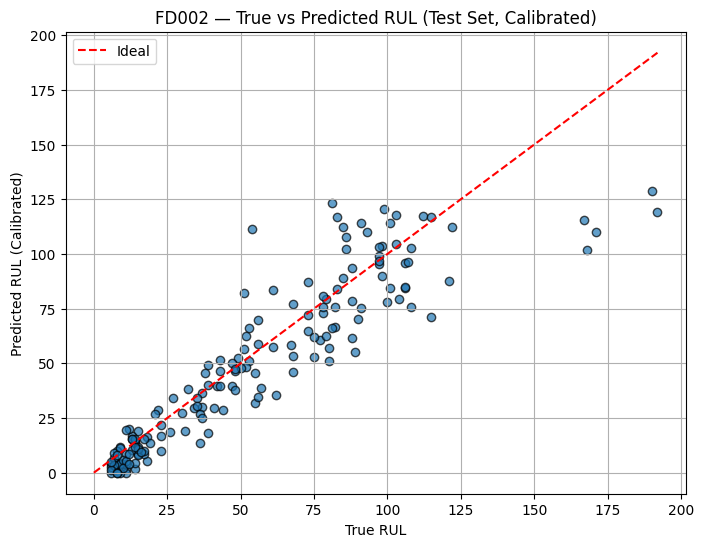

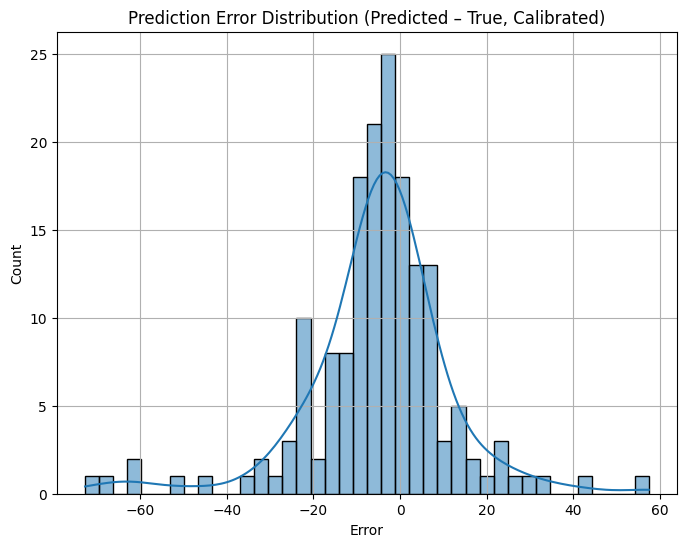

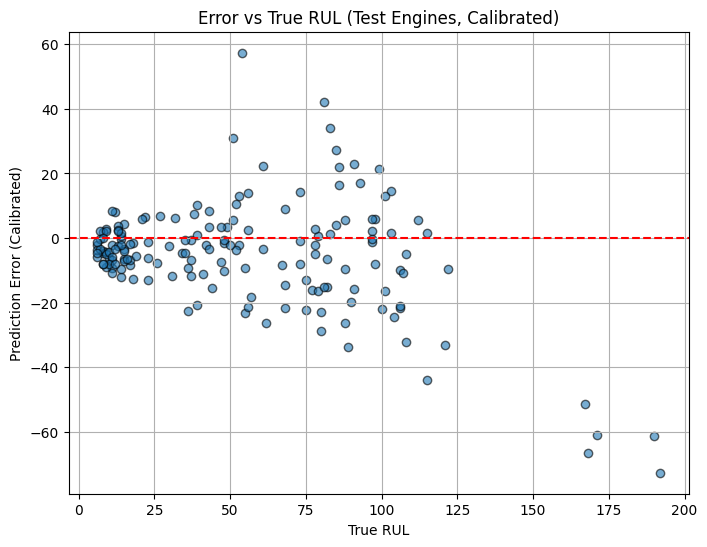


 TOP 10 WORST TEST ENGINES (Highest Error, Calibrated) 


,unit,True_RUL,Pred_RUL,Error,Abs_Error
134,135,192,119.364067,-72.635933,72.635933
72,73,168,101.615875,-66.384125,66.384125
154,155,190,128.740616,-61.259384,61.259384
104,105,171,109.906624,-61.093376,61.093376
12,13,54,111.347565,57.347565,57.347565
90,91,167,115.546082,-51.453918,51.453918
102,103,115,71.074799,-43.925201,43.925201
143,144,81,123.143753,42.143753,42.143753
17,18,83,117.063087,34.063087,34.063087
153,154,89,55.262730,-33.737270,33.737270



Saved detailed calibrated test results to:
/content/drive/MyDrive/OIL PREDICTIVE MAINTAINANCE/CMaps/FD002_TEST_RESULTS_CALIBRATED.csv


In [37]:
# CELL 37 — FD002 TEST PLOT VISUALIZATION & ERROR ANALYSIS

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("FD002 TEST PLOTS & ERROR ANALYSIS (CALIBRATED)")

# Use the calibrated results from df_test_out
true_rul = df_test_out["True_RUL"].values
pred_rul = df_test_out["Predicted_RUL"].values   # NASA-calibrated predictions
errors   = pred_rul - true_rul

# 1. SCATTER PLOT — True vs Predicted (Calibrated)

plt.figure(figsize=(8, 6))
plt.scatter(true_rul, pred_rul, alpha=0.7, edgecolor="k")
max_val = max(true_rul.max(), pred_rul.max())
plt.plot([0, max_val], [0, max_val], "r--", label="Ideal")
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL (Calibrated)")
plt.title("FD002 — True vs Predicted RUL (Test Set, Calibrated)")
plt.grid(True)
plt.legend()
plt.show()


# 2. ERROR HISTOGRAM

plt.figure(figsize=(8, 6))
sns.histplot(errors, bins=40, kde=True)
plt.title("Prediction Error Distribution (Predicted – True, Calibrated)")
plt.xlabel("Error")
plt.ylabel("Count")
plt.grid(True)
plt.show()


# 3. ERROR SCATTER — Error vs True RUL

plt.figure(figsize=(8, 6))
plt.scatter(true_rul, errors, alpha=0.6, edgecolor="k")
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("True RUL")
plt.ylabel("Prediction Error (Calibrated)")
plt.title("Error vs True RUL (Test Engines, Calibrated)")
plt.grid(True)
plt.show()


# 4. PRINT worst engines (absolute error sorting)

df_errors = pd.DataFrame({
    "unit": np.arange(1, len(true_rul) + 1),
    "True_RUL": true_rul,
    "Pred_RUL": pred_rul,
    "Error": errors,
    "Abs_Error": np.abs(errors)
})

df_errors_sorted = df_errors.sort_values("Abs_Error", ascending=False)

print("\n TOP 10 WORST TEST ENGINES (Highest Error, Calibrated) ")
display(df_errors_sorted.head(10))


# 5. Save results to Drive (Calibrated predictions)

save_path = "/content/drive/MyDrive/OIL PREDICTIVE MAINTAINANCE/CMaps/FD002_TEST_RESULTS_CALIBRATED.csv"
df_errors.to_csv(save_path, index=False)

print(f"\nSaved detailed calibrated test results to:\n{save_path}")



# **38. NASA ASYMMETRIC SCORE (FD002 TEST) — CLEAN VERSION**

This cell computes the **NASA CMAPSS asymmetric scoring function** for the FD002 test set using the **calibrated predictions** from the Hybrid LSTM–GRU model.

NASA’s asymmetric metric penalizes:
- **Late predictions (overestimating RUL)** much more heavily  
- **Early predictions (underestimating RUL)** more mildly  

This reflects real aerospace risk: predicting too much remaining life is far more dangerous than predicting too little.

**What this cell does**
1. Loads the final calibrated test predictions (`df_test_out`).
2. Implements the official NASA asymmetric scoring function:
   - Early error → `exp(-d/13) - 1`
   - Late error → `exp(d/10) - 1`
3. Computes:
   - **Total NASA score**
   - **Mean NASA score**
4. Saves results to Google Drive for reporting and documentation.

These metrics are essential because many CMAPSS papers and competitions use NASA’s asymmetric score instead of RMSE/MAE to evaluate safety-critical prediction performance.

In [38]:
# 38. NASA ASYMMETRIC SCORE (FD002 TEST) — CLEAN VERSION

import math
import numpy as np
import pandas as pd

print(" FD002 NASA Asymmetric Score (TEST) ")


try:
    df_fd002 = df_test_out.copy()
    print(" Using df_test_out for NASA scoring.")
except NameError:
    raise RuntimeError("'df_test_out' not found.")

# Extract arrays
y_true = df_fd002["True_RUL"].values
y_pred = df_fd002["Predicted_RUL"].values

# NASA asymmetric score (return total + mean)
def nasa_score_with_mean(true, pred):
    total = 0.0
    for t, p in zip(true, pred):
        d = p - t
        if d < 0:      # early prediction (good, smaller penalty)
            total += math.exp(-d / 13.0) - 1.0
        else:          # late prediction (bad, higher penalty)
            total += math.exp(d / 10.0) - 1.0
    mean = total / len(true)
    return total, mean

score_total, score_mean = nasa_score_with_mean(y_true, y_pred)

print(f"\nNASA SCORE (FD002 TEST): {score_total:.4f}")
print(f"Mean NASA score (FD002 TEST): {score_mean:.4f}")

# Store as globals for config saving
NASA_TOTAL_FD002_TEST = float(score_total)
NASA_MEAN_FD002_TEST = float(score_mean)

# Save to Drive
save_path = "/content/drive/MyDrive/OIL PREDICTIVE MAINTAINANCE/CMaps/FD002_NASA_SCORE.txt"
with open(save_path, "w") as f:
    f.write(f"FD002 NASA Asymmetric Score (TEST): {score_total:.4f}\n")
    f.write(f"FD002 Mean NASA (TEST): {score_mean:.4f}\n")

print(f" NASA score saved to: {save_path}")



 FD002 NASA Asymmetric Score (TEST) 
 Using df_test_out for NASA scoring.

NASA SCORE (FD002 TEST): 1429.1490
Mean NASA score (FD002 TEST): 8.5068
 NASA score saved to: /content/drive/MyDrive/OIL PREDICTIVE MAINTAINANCE/CMaps/FD002_NASA_SCORE.txt


# **39. SAVE FD002 SCALER + CONFIG**

This cell stores all required artifacts so the FD002 model can be used later in an inference or deployment pipeline.

Saved items include:

- Feature scaler (MinMaxScaler for input features)
- RUL scaler (MinMaxScaler for target)
- Raw feature list and final engineered feature list
- Sequence length used for training (100)
- Path to the best model file
- NASA calibration values (shift + max RUL cap)
- Validation and test metrics for documentation

Everything is combined into a single `FD002_config.json` file so any script (Colab, VS Code, FastAPI, etc.) can load the correct preprocessing steps and model settings without retraining.

In [39]:
# 39. SAVE FD002 SCALERS + JSON CONFIG


import joblib
import os
import json

print(" SAVING FD002 SCALERS + CONFIG ")


# 1. Ensure save directory exists

SAVE_DIR = "/content/drive/MyDrive/OIL PREDICTIVE MAINTAINANCE/CMaps/FD002_CONFIG"
os.makedirs(SAVE_DIR, exist_ok=True)

# 2. Save feature scaler + RUL scaler

feature_scaler_path_fd002 = os.path.join(SAVE_DIR, "FD002_feature_scaler.gz")
rul_scaler_path_fd002     = os.path.join(SAVE_DIR, "FD002_rul_scaler.gz")

joblib.dump(scaler_fd002, feature_scaler_path_fd002)
joblib.dump(rul_scaler,   rul_scaler_path_fd002)

print(" Saved feature scaler  ->", feature_scaler_path_fd002)
print(" Saved RUL scaler      ->", rul_scaler_path_fd002)


# 3. Also keep simple text files for quick inspection

with open(os.path.join(SAVE_DIR, "feature_cols.txt"), "w") as f:
    for col in feature_cols:
        f.write(col + "\n")

with open(os.path.join(SAVE_DIR, "final_feature_cols.txt"), "w") as f:
    for col in feature_cols_final:
        f.write(col + "\n")

with open(os.path.join(SAVE_DIR, "seq_len.txt"), "w") as f:
    f.write(str(SEQ_LEN))   # should be 100 for best model

print(" FD002 plain-text metadata saved (feature lists + seq_len).")


# 4. Build FD002 JSON CONFIG


# Best model is the Hybrid LSTM–GRU with seq_len=100 we trained & used
best_model_name_fd002 = "HYBRID_LSTM_GRU_SEQ100"

# MODEL_PATH was defined in the earlier "SAVE BEST FD002 MODEL" cell
# and points to: ".../FD002_Hybrid_LSTM_GRU_seq100.h5"

try:
    _ = MODEL_PATH
except NameError:
    raise RuntimeError(" MODEL_PATH not found. Run the 'SAVE BEST FD002 MODEL' cell first.")

# BEST_NASA_SHIFT + MAX_RUL_NASA were set
try:
    _ = BEST_NASA_SHIFT
    _ = MAX_RUL_NASA
except NameError:
    raise RuntimeError(" BEST_NASA_SHIFT / MAX_RUL_NASA not found.")

# Validation metrics for best model
try:
    _ = val_rmse_hybrid
    _ = val_mae_hybrid
except NameError:
    # Fallback if variable names differ
    val_rmse_hybrid = float("nan")
    val_mae_hybrid  = float("nan")


try:
    _ = test_rmse
    _ = test_mae
except NameError:
    test_rmse = float("nan")
    test_mae  = float("nan")


try:
    _ = NASA_TOTAL_FD002_TEST
    _ = NASA_MEAN_FD002_TEST
except NameError:
    NASA_TOTAL_FD002_TEST = float("nan")
    NASA_MEAN_FD002_TEST  = float("nan")

fd002_config = {
    "best_model_name": best_model_name_fd002,
    "model_path": MODEL_PATH,
    "feature_scaler_path": feature_scaler_path_fd002,
    "rul_scaler_path": rul_scaler_path_fd002,

    # raw features after constant-column removal
    "feature_columns": feature_cols,

    # fully engineered + scaled feature set used for sequences
    "final_feature_columns": feature_cols_final,

    # sequence length for the best model
    "sequence_length": int(SEQ_LEN),

    # NASA calibration used at inference time
    "nasa_shift": float(BEST_NASA_SHIFT),
    "nasa_max_rul_cap": float(MAX_RUL_NASA),

    # --- extra: metrics for documentation / dashboards ---
    "val_rmse": float(val_rmse_hybrid),
    "val_mae": float(val_mae_hybrid),
    "test_rmse": float(test_rmse),
    "test_mae": float(test_mae),
    "nasa_total_test": float(NASA_TOTAL_FD002_TEST),
    "nasa_mean_test": float(NASA_MEAN_FD002_TEST),
}

config_path_fd002 = os.path.join(SAVE_DIR, "FD002_config.json")
with open(config_path_fd002, "w") as f:
    json.dump(fd002_config, f, indent=4)

print("\n FD002 JSON config saved to:")
print(config_path_fd002)
print(" FD002 CONFIG SAVE COMPLETE ")


 SAVING FD002 SCALERS + CONFIG 
 Saved feature scaler  -> /content/drive/MyDrive/OIL PREDICTIVE MAINTAINANCE/CMaps/FD002_CONFIG/FD002_feature_scaler.gz
 Saved RUL scaler      -> /content/drive/MyDrive/OIL PREDICTIVE MAINTAINANCE/CMaps/FD002_CONFIG/FD002_rul_scaler.gz
 FD002 plain-text metadata saved (feature lists + seq_len).

 FD002 JSON config saved to:
/content/drive/MyDrive/OIL PREDICTIVE MAINTAINANCE/CMaps/FD002_CONFIG/FD002_config.json
 FD002 CONFIG SAVE COMPLETE 
